### Acknowledgement
Name: Zuha Aqib     
ERP ID: 26106    
Section: 10am Miss Solat     
Date: (written on) 08-Mar-25    

code has been taken from Miss Solat's code files and written by Zuha themselves. 

In [87]:
from datetime import datetime
print("Last time code executed:", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

Last time code executed: 2025-03-09 14:53:25


In [88]:
erp = 26106 
# will be referenced later on in the code when we use it for random_state
erp

26106

# Imports
here we import all the necessary libraries and modules

In [89]:
# to load the dataset
import warnings
warnings.filterwarnings('ignore')

# to handle the data and perform numerical operations on it
import pandas as pd
import numpy as np

# to do natural language processing
import nltk

# preprocessing: to clean the data
import re

# preprocessing: stop words removal
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# preprocessing: words tokenization
from nltk.tokenize import word_tokenize

# preprocessing: stemmming and lemmatization
from nltk.stem import WordNetLemmatizer

# model running
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# clustering: k means
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to plot the graph
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns

# Time Displayer
this code is a function that we will call at multiple instances of the code to see how long it took to run the code to see when it ran

In [90]:
# Function to get current date and time as a string
def get_current_datetime():
    return datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Load the Dataset
Here we load the dataset from a csv file and then save it into a variable

In [91]:
dummy_dataframe = pd.read_csv("dataset/news_Feb_14.csv")
dummy_dataframe = dummy_dataframe.iloc[:, 0]  # Select only the headline column
documents = dummy_dataframe.tolist()  # Convert to list
documents

['ECC endorses purchase of $582mn capital shares in BRICS’s New Development Bank',
 'Netanyahu’s statement to establish Palestinian state in Saudi Arabia irresponsible, provocative: FO',
 'India, US agree to resolve trade and tariff rows after Trump-Modi talks',
 'Aurangzeb discusses Pakistan’s structural reforms with IFC chief',
 'HBL, S&P Global launch Pakistan’s first manufacturing PMI',
 'KSE-100 closes 479 points lower as late-session selling erases intra-day gains',
 'PPL executes agreements for Sui Gas Field operations',
 'Hubco Green, PSO collaborate to setup EV charging infrastructure across Pakistan',
 'Rupee records marginal improvement against US dollar',
 'At least 9 dead, 7 injured in Balochistan’s Harnai blast',
 'Gold adds to record rally, reaches Rs306,200 per tola in Pakistan',
 'IMF’s 2024 Article IV report, and debate on inflation—I',
 'Pakistan CPI 2024 – deep-rooted corruption persists',
 '‘Like a wormhole’: Musk promises ‘Dubai Loop’ tunnel network',
 'Reforming 

In [92]:
original_headlines = documents.copy()

# Preprocessing
here we perform the preprocessing of data like:
- lowercase text
- stopword removal
- stemming or lemmatization
- n-grams

## Lowercase Conversion
here we convert our text to lowercase

In [93]:
documents = [document.lower() for document in documents]

print("Finished executing at:", get_current_datetime())
documents

Finished executing at: 2025-03-09 14:53:25


['ecc endorses purchase of $582mn capital shares in brics’s new development bank',
 'netanyahu’s statement to establish palestinian state in saudi arabia irresponsible, provocative: fo',
 'india, us agree to resolve trade and tariff rows after trump-modi talks',
 'aurangzeb discusses pakistan’s structural reforms with ifc chief',
 'hbl, s&p global launch pakistan’s first manufacturing pmi',
 'kse-100 closes 479 points lower as late-session selling erases intra-day gains',
 'ppl executes agreements for sui gas field operations',
 'hubco green, pso collaborate to setup ev charging infrastructure across pakistan',
 'rupee records marginal improvement against us dollar',
 'at least 9 dead, 7 injured in balochistan’s harnai blast',
 'gold adds to record rally, reaches rs306,200 per tola in pakistan',
 'imf’s 2024 article iv report, and debate on inflation—i',
 'pakistan cpi 2024 – deep-rooted corruption persists',
 '‘like a wormhole’: musk promises ‘dubai loop’ tunnel network',
 'reforming 

## Data Cleaning
here we clean the data

In [94]:
import re
import unicodedata

def clean_text(text):
    text = text.encode('ascii', 'ignore').decode()  # Remove non-ASCII characters
    text = unicodedata.normalize("NFKD", text)  # Normalize Unicode text
    
    # Separate numbers attached to words
    text = re.sub(r'(?<=\d)(?=[a-zA-Z])', ' ', text)  # number-word
    text = re.sub(r'(?<=[a-zA-Z])(?=\d)', ' ', text)  # word-number
    
    text = text.replace("-", " ") # replace hyphens with spaces to tokenize the numbers and words
    text = re.sub(r'[^\w\s,]', '', text)  # Remove everything except words, numbers, and commas
    text = re.sub(r'\s+', ' ', text).strip()   # remove extra spaces
    
    return text

In [95]:
documents = [clean_text(text) for text in documents]
documents

['ecc endorses purchase of 582 mn capital shares in bricss new development bank',
 'netanyahus statement to establish palestinian state in saudi arabia irresponsible, provocative fo',
 'india, us agree to resolve trade and tariff rows after trump modi talks',
 'aurangzeb discusses pakistans structural reforms with ifc chief',
 'hbl, sp global launch pakistans first manufacturing pmi',
 'kse 100 closes 479 points lower as late session selling erases intra day gains',
 'ppl executes agreements for sui gas field operations',
 'hubco green, pso collaborate to setup ev charging infrastructure across pakistan',
 'rupee records marginal improvement against us dollar',
 'at least 9 dead, 7 injured in balochistans harnai blast',
 'gold adds to record rally, reaches rs 306,200 per tola in pakistan',
 'imfs 2024 article iv report, and debate on inflationi',
 'pakistan cpi 2024 deep rooted corruption persists',
 'like a wormhole musk promises dubai loop tunnel network',
 'reforming pension funds i

## Stop Words Removal
here we remove stop words. we have three options of:
- either declaring all possible stop words and then iteratively checking each word in the document if its a stop word and then adding the non-stop words. 
```
sw = ["from","of","and", "on","for", "the","have","a","be","to","in","will","if","by","into","as"]
docs_list = []
for d in document: 
    d_nlp = nlp(d.lower())
    t_list = []
    for token in d_nlp:
        tok_lem = str(token.lemma_)
        if (tok_lem not in sw):
            t_list.append(tok_lem)
    str_ = ' '.join(t_list) 
    docs_list.append(str_)
docs_list
```
However this is not a good practice. 
- pulling stop words from ```ntlk``` library: 
```
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
documents_no_stopwords = [" ".join([word for word in doc.split() if word not in stop_words]) 
```
However after running this code it didnt not remove stop words thus i removed it
- intializing stop_words in ```CountVectorizer()``` however here we are not using it
- using the ```ENGLISH_STOP_WORDS``` in ```sklearn```
```
tokens = [word for word in tokens if word not in stopwords.words('english') and word not in ENGLISH_STOP_WORDS]  
```
Lets try it and see it how it goes.

In [96]:
# Tokenize each document
tokenized_docs = [word_tokenize(doc) for doc in documents] 

# Remove stop words
filtered_docs = [[word for word in doc if word not in stopwords.words('english') and word not in ENGLISH_STOP_WORDS] for doc in tokenized_docs]

# Convert back to sentences if needed
documents = [" ".join(doc) for doc in filtered_docs]

documents

['ecc endorses purchase 582 mn capital shares bricss new development bank',
 'netanyahus statement establish palestinian state saudi arabia irresponsible , provocative fo',
 'india , agree resolve trade tariff rows trump modi talks',
 'aurangzeb discusses pakistans structural reforms ifc chief',
 'hbl , sp global launch pakistans manufacturing pmi',
 'kse 100 closes 479 points lower late session selling erases intra day gains',
 'ppl executes agreements sui gas field operations',
 'hubco green , pso collaborate setup ev charging infrastructure pakistan',
 'rupee records marginal improvement dollar',
 '9 dead , 7 injured balochistans harnai blast',
 'gold adds record rally , reaches rs 306,200 tola pakistan',
 'imfs 2024 article iv report , debate inflationi',
 'pakistan cpi 2024 deep rooted corruption persists',
 'like wormhole musk promises dubai loop tunnel network',
 'reforming pension funds pakistan sustainable approach',
 'cjp afridi administers oath newly appointed sc judges',
 '

## Reduction
here we change words to a smaller common form instead of the 's. We do this using two ways:
- stemming
- lemmatization

here we perform lemmatization as in the previous assignment, lemmatization had worked much better

### Lemmatization
this also reduces words to their singular form and is said to be better as it only reduces to words in the dictionary. after our 48 trials in the previous assignment, lemmatization was much better.

In [97]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_doc(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)

In [98]:
documents = [lemmatize_doc(doc) for doc in documents]
documents

['ecc endorses purchase 582 mn capital share bricss new development bank',
 'netanyahus statement establish palestinian state saudi arabia irresponsible , provocative fo',
 'india , agree resolve trade tariff row trump modi talk',
 'aurangzeb discusses pakistan structural reform ifc chief',
 'hbl , sp global launch pakistan manufacturing pmi',
 'kse 100 close 479 point lower late session selling erases intra day gain',
 'ppl executes agreement sui gas field operation',
 'hubco green , pso collaborate setup ev charging infrastructure pakistan',
 'rupee record marginal improvement dollar',
 '9 dead , 7 injured balochistans harnai blast',
 'gold add record rally , reach r 306,200 tola pakistan',
 'imf 2024 article iv report , debate inflationi',
 'pakistan cpi 2024 deep rooted corruption persists',
 'like wormhole musk promise dubai loop tunnel network',
 'reforming pension fund pakistan sustainable approach',
 'cjp afridi administers oath newly appointed sc judge',
 'solar panel import 8

## N-Grams
here we decide how we want the words to be tokenized, either they are
- unigram: singular
- bigram: pairs (doubular)

for this assignment, we will focus on unigrams.

In [99]:
# because we want unigrams, we DO NOT have to do anything and we will leave it the way it is

# Vectorization
here we convert the text to numerical format for the model to understand it. we have four ways to do it:
- word2Vec
- doc2vec

in this code we are exploring the first method

## Word2Vec
in word2vec we have two methods:
- cbow architecture (target is predicted by context)
- skipgram (target predicts context)

In [100]:
# for sg variable
sg = 0 # CBOW
# sg = 1 # Skip-Gram

if sg == 0:
    model_type = 'CBOW'
else:
    model_type = 'Skipgram'

print(f"sg={sg}, model={model_type}")

sg=0, model=CBOW


### Variables to set
here we set variables like vector_size, window_size, count of epochs etc. we define them here so that in the code we dont have to change them. We can easily change them here and the code will change accordingly.

one thing to note here is that before starting the assignment i will make a list of each variable and what i want to test. then i will iterate over each variable keeping rest fixed, and write a loop to iterate over that variable and then i will select that as best. then for the next i will use its list but that previous one will be in its best. this will help me run as many things as i want in one code run.

In [101]:
vector_sizes = [50, 100, 150, 200, 250, 300]
selected_vector_size = vector_sizes[0]

In [102]:
windows = [3, 5, 7, 10, 12, 15, 20]
selected_window = windows[0]

In [103]:
epochs = [50, 100, 150, 200, 250]
selected_epoch = epochs[0]

### Code declaration
here we declare our code using the following syntax

In [104]:
def get_avg_word2vec(tokens, model, vector_size=300):
    vectors = [model.wv[word] for word in tokens if word in model.wv]  
    return np.mean(vectors, axis=0) if vectors else np.zeros(vector_size) 

In [105]:
def run_word2vec (docs, vector_size, window_size, epoch):
    word2vec_model = Word2Vec(
        sentences=docs,                        # Tokenized text
        vector_size=vector_size,           # Each word is represented by a x-dimensional vector
        window=window_size,                     # Context window size
        min_count=1,                                # Ignores words that appear less than 'min_count' times
        workers=4,                                  # Number of CPU cores used
        sg=sg,                   
        epochs=epoch                       # Number of training iterations
    )
    # print(word2vec_model)
    
    # Convert the list to a Pandas Series
    documents_series = pd.Series(docs)

    docs = documents_series.apply(lambda x: get_avg_word2vec(x, word2vec_model))    
    docs = np.array(docs.tolist())
    
    # print(docs)
    
    return docs

# K Means Clustering
here we cluster the documents into similar categories using k means clustering algorithm. we will be testing the algorithm for three values of k: 5, 9 and 13

In [106]:
def display_k_means(k, data):
    print(f"Displaying {k} start time:", get_current_datetime())
    
    svd = TruncatedSVD(n_components=2, random_state=42)
    data = svd.fit_transform(data)
    
    kmeans = KMeans(n_clusters=k, random_state=erp)
    labels = kmeans.fit_predict(data)
    
    # Convert to DataFrame for visualization
    df_viz = pd.DataFrame({'X': data[:, 0], 'Y': data[:, 1], 'Cluster': labels})

    # Scatter plot of clusters
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_viz, x='X', y='Y', hue='Cluster', palette='tab10', s=100, edgecolor='black')
    plt.title("K-Means Clustering Visualization (2D Projection)")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend(title="Cluster")
    plt.show()
    
    print("Finished displaying at:", get_current_datetime(), "\n")

In [107]:
def run_k_means(k, data, results, vector_size, window, epoch):
    print(f"Executing {k} start time:", get_current_datetime())
    
    kmeans = KMeans(n_clusters=k, random_state=erp)
    labels = kmeans.fit_predict(data)
    
    wss = kmeans.inertia_  # Within-Cluster Sum of Squares
    silhouette_avg = silhouette_score(data, labels)  # Silhouette Score
    
    print(f"K={k}: Silhouette Score and WSS={silhouette_avg:.4f}\t{wss:.4f}")
    
    results.append([k, f'Word2Vec', vector_size, window, epoch, model_type, silhouette_avg, wss])
    
    # Create a DataFrame to store headlines with their assigned clusters
    df_clusters = pd.DataFrame({'Headline': original_headlines, 'Cluster': labels})

    # Display sample headlines per cluster
    for cluster in range(k):
        print(f"\nCluster {cluster}:")
        sample_headlines = df_clusters[df_clusters["Cluster"] == cluster].sample(n=min(5, len(df_clusters[df_clusters["Cluster"] == cluster])), random_state=erp)
        for idx, row in sample_headlines.iterrows():
            print(f"- {row['Headline']}")
    
    display_k_means(k, data)
    
    print("Finished executing at:", get_current_datetime(), "\n")
    
    return silhouette_avg, wss

## Code Running
here we run the code in a for-loop, because we have many variables we need to test with k-means. thus we test them here.

In [108]:
copy_of_docs = documents

In [109]:
window = selected_window
epoch = selected_epoch
# vector_size = selected_vector_size
# the variable that is commented means that is the variable being tested

In [110]:
# define a output that will save each case WSS and silhoutee so that it can be saved into a csv file later on
results = []

In [111]:
# define an output that will save each WSS with its k so that we can plot a scree plot later on
wss_scores = []

In [112]:
# define a variable that will save the best combination for reference at the end
best_combination = []
best_WSS = 100000000000000000000000000 # we want lowest wss so we start with large value
best_Sil = 0    # we want max sil so we start with small value

In [113]:
def run_combinations(k, best_combination, best_Sil, best_WSS):
    sum_wss = 0
    count_wss = 0

    for vector_size in vector_sizes:
        print("Executed at:", get_current_datetime(), "\n")
        documents = run_word2vec(copy_of_docs, vector_size, window, epoch)
        print(f"sg={sg}, Vector_Size={vector_size}, Window={window}, Epoch={epoch}")
        print("Finished displaying at:", get_current_datetime(), "\n")
        sil, wss = run_k_means(k, documents, results, vector_size, window, epoch)
        
        # sum the wss to find average for elbow plot
        sum_wss += wss
        count_wss += 1
        
        # compute max(sil, best_sil) and min(wss, best_wss) to find the BEST
        if sil > best_Sil and wss < best_WSS:
            best_combination = [k, vector_size, window, epoch, sil, wss]
            best_WSS = wss
            best_Sil = sil
        else:
            # if best not found, pick if WSS is best however SIL is not best but it should be within 0.1 range
            sil_diff = sil - best_Sil
            wss_diff = best_WSS - wss
            if sil_diff > 0 and sil_diff < 0.1 and wss_diff > 0:
                best_combination = [k, vector_size, window, epoch, sil, wss]
                best_WSS = wss
                best_Sil = sil

    # once all combinations are tested, compute average and append that for elbow plots for that k
    avg_wss = sum_wss / count_wss
    wss_scores.append([k, avg_wss])
    
    return best_combination, best_Sil, best_WSS

2025-03-09 14:53:28,374 : INFO : collecting all words and their counts
2025-03-09 14:53:28,377 : WARNING : Each 'sentences' item should be a list of words (usually unicode strings). First item here is instead plain <class 'str'>.
2025-03-09 14:53:28,378 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-03-09 14:53:28,384 : INFO : collected 38 word types from a corpus of 24723 raw words and 453 sentences
2025-03-09 14:53:28,386 : INFO : Creating a fresh vocabulary
2025-03-09 14:53:28,387 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 38 unique words (100.00% of original 38, drops 0)', 'datetime': '2025-03-09T14:53:28.387623', 'gensim': '4.3.3', 'python': '3.12.9 (tags/v3.12.9:fdb8142, Feb  4 2025, 15:27:58) [MSC v.1942 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'prepare_vocab'}
2025-03-09 14:53:28,389 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 24723 word corpus (100.00% of origi

Executed at: 2025-03-09 14:53:28 



2025-03-09 14:53:28,569 : INFO : EPOCH 5: training on 24723 raw words (4608 effective words) took 0.0s, 302103 effective words/s
2025-03-09 14:53:28,599 : INFO : EPOCH 6: training on 24723 raw words (4633 effective words) took 0.0s, 297332 effective words/s
2025-03-09 14:53:28,626 : INFO : EPOCH 7: training on 24723 raw words (4655 effective words) took 0.0s, 307095 effective words/s
2025-03-09 14:53:28,649 : INFO : EPOCH 8: training on 24723 raw words (4699 effective words) took 0.0s, 379779 effective words/s
2025-03-09 14:53:28,676 : INFO : EPOCH 9: training on 24723 raw words (4746 effective words) took 0.0s, 346588 effective words/s
2025-03-09 14:53:28,697 : INFO : EPOCH 10: training on 24723 raw words (4673 effective words) took 0.0s, 431706 effective words/s
2025-03-09 14:53:28,723 : INFO : EPOCH 11: training on 24723 raw words (4726 effective words) took 0.0s, 272551 effective words/s
2025-03-09 14:53:28,745 : INFO : EPOCH 12: training on 24723 raw words (4636 effective words) t

sg=0, Vector_Size=50, Window=3, Epoch=50
Finished displaying at: 2025-03-09 14:53:29 

Executing 5 start time: 2025-03-09 14:53:29
K=5: Silhouette Score and WSS=0.1645	5.5811

Cluster 0:
- Drake addresses rap beef with Joe Budden and Kendrick Lamar on new song 'Gimme a Hug'
- Pakistan, Türkiye reaffirm commitment to strengthen trade, investment ties
- Musk threatens to withdraw $97B OpenAI bid unless nonprofit shift stops
- Kinnaird College, PMAA equip young women with self-defense skills
- Still Angry at Your Ex? The San Antonio Zoo Will Name a Cockroach After Them & Feed it To Animals

Cluster 1:
- Israeli military killed 85 journalists in 2024: CPJ
- UK Pound further climbs up against Pakistani rupee – 14 February 2025
- Journalist killings reach record high in 2024
- Govt hikes RLNG prices by up to 1.86pc
- Feb 14 last date to submit third installment for Hajj 2025

Cluster 2:
- Saudi Arabia to host Arab summit on Trump’s Gaza plan
- First Lady of Turkiye visits Maarif Internationa

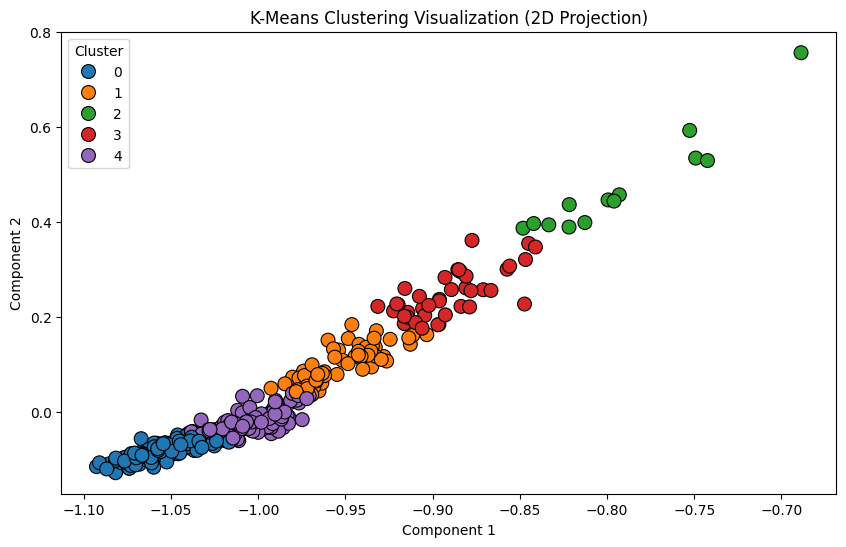

2025-03-09 14:53:30,325 : INFO : collecting all words and their counts
2025-03-09 14:53:30,327 : WARNING : Each 'sentences' item should be a list of words (usually unicode strings). First item here is instead plain <class 'str'>.
2025-03-09 14:53:30,328 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-03-09 14:53:30,334 : INFO : collected 38 word types from a corpus of 24723 raw words and 453 sentences
2025-03-09 14:53:30,336 : INFO : Creating a fresh vocabulary
2025-03-09 14:53:30,338 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 38 unique words (100.00% of original 38, drops 0)', 'datetime': '2025-03-09T14:53:30.338618', 'gensim': '4.3.3', 'python': '3.12.9 (tags/v3.12.9:fdb8142, Feb  4 2025, 15:27:58) [MSC v.1942 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'prepare_vocab'}
2025-03-09 14:53:30,340 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 24723 word corpus (100.00% of origi

Finished displaying at: 2025-03-09 14:53:30 

Finished executing at: 2025-03-09 14:53:30 

Executed at: 2025-03-09 14:53:30 



2025-03-09 14:53:30,512 : INFO : EPOCH 5: training on 24723 raw words (4655 effective words) took 0.0s, 645685 effective words/s
2025-03-09 14:53:30,540 : INFO : EPOCH 6: training on 24723 raw words (4752 effective words) took 0.0s, 531151 effective words/s
2025-03-09 14:53:30,563 : INFO : EPOCH 7: training on 24723 raw words (4683 effective words) took 0.0s, 401878 effective words/s
2025-03-09 14:53:30,594 : INFO : EPOCH 8: training on 24723 raw words (4754 effective words) took 0.0s, 279706 effective words/s
2025-03-09 14:53:30,623 : INFO : EPOCH 9: training on 24723 raw words (4695 effective words) took 0.0s, 291038 effective words/s
2025-03-09 14:53:30,649 : INFO : EPOCH 10: training on 24723 raw words (4739 effective words) took 0.0s, 288531 effective words/s
2025-03-09 14:53:30,690 : INFO : EPOCH 11: training on 24723 raw words (4667 effective words) took 0.0s, 216683 effective words/s
2025-03-09 14:53:30,717 : INFO : EPOCH 12: training on 24723 raw words (4665 effective words) t

sg=0, Vector_Size=100, Window=3, Epoch=50
Finished displaying at: 2025-03-09 14:53:32 

Executing 5 start time: 2025-03-09 14:53:32
K=5: Silhouette Score and WSS=0.1897	6.3231

Cluster 0:
- Centre exploring olive production on commercial basis in Chagai
- Govt merges aviation ministry into defence, narcotics control into interior under rightsizing plan
- Hubco expands into EV charging sector with new subsidiary, partners with PSO
- Pakistan keen to increase trade, investment with Japan: Governor
- Apple’s App Tracking Transparency tool under scrutiny in Germany

Cluster 1:
- South Green book berth in Rangers Cup Basketball final
- Former SC judge Sheikh Azmat Saeed’s funeral to be held today
- Pakistan’s greatest ODI chases: A look back after historic win over South Africa
- Ohio State Buckeyes faces quarterback battle, adds Matt Patricia as DC
- US awaits Arab plan for Gaza, Trump plan remains default option: Washington

Cluster 2:
- PAF’s JF-17 to perform at Champions Trophy opening 

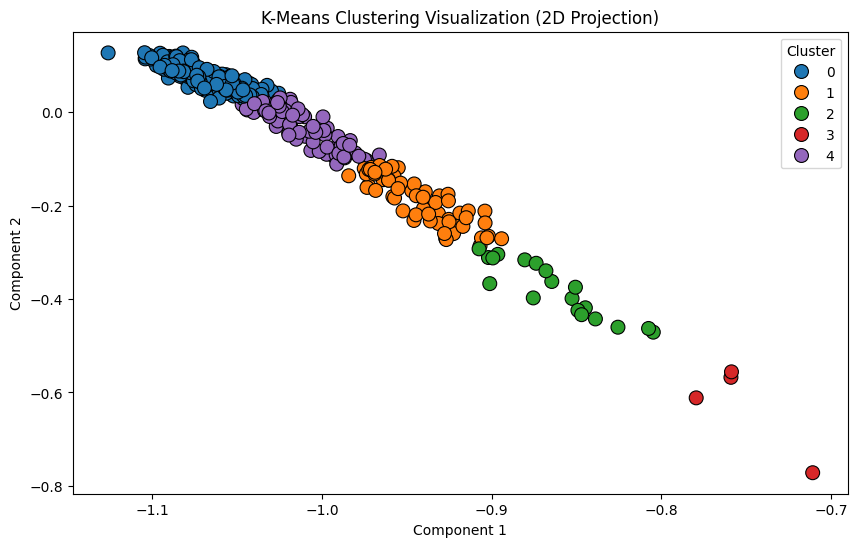

2025-03-09 14:53:32,563 : INFO : collecting all words and their counts
2025-03-09 14:53:32,565 : WARNING : Each 'sentences' item should be a list of words (usually unicode strings). First item here is instead plain <class 'str'>.
2025-03-09 14:53:32,568 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-03-09 14:53:32,575 : INFO : collected 38 word types from a corpus of 24723 raw words and 453 sentences
2025-03-09 14:53:32,576 : INFO : Creating a fresh vocabulary
2025-03-09 14:53:32,579 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 38 unique words (100.00% of original 38, drops 0)', 'datetime': '2025-03-09T14:53:32.578638', 'gensim': '4.3.3', 'python': '3.12.9 (tags/v3.12.9:fdb8142, Feb  4 2025, 15:27:58) [MSC v.1942 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'prepare_vocab'}
2025-03-09 14:53:32,580 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 24723 word corpus (100.00% of origi

Finished displaying at: 2025-03-09 14:53:32 

Finished executing at: 2025-03-09 14:53:32 

Executed at: 2025-03-09 14:53:32 



2025-03-09 14:53:32,751 : INFO : EPOCH 9: training on 24723 raw words (4592 effective words) took 0.0s, 331325 effective words/s
2025-03-09 14:53:32,773 : INFO : EPOCH 10: training on 24723 raw words (4645 effective words) took 0.0s, 617145 effective words/s
2025-03-09 14:53:32,794 : INFO : EPOCH 11: training on 24723 raw words (4720 effective words) took 0.0s, 442229 effective words/s
2025-03-09 14:53:32,809 : INFO : EPOCH 12: training on 24723 raw words (4663 effective words) took 0.0s, 646149 effective words/s
2025-03-09 14:53:32,823 : INFO : EPOCH 13: training on 24723 raw words (4613 effective words) took 0.0s, 631243 effective words/s
2025-03-09 14:53:32,837 : INFO : EPOCH 14: training on 24723 raw words (4775 effective words) took 0.0s, 565571 effective words/s
2025-03-09 14:53:32,852 : INFO : EPOCH 15: training on 24723 raw words (4664 effective words) took 0.0s, 1274805 effective words/s
2025-03-09 14:53:32,866 : INFO : EPOCH 16: training on 24723 raw words (4658 effective wor

sg=0, Vector_Size=150, Window=3, Epoch=50
Finished displaying at: 2025-03-09 14:53:33 

Executing 5 start time: 2025-03-09 14:53:33
K=5: Silhouette Score and WSS=0.2065	5.6924

Cluster 0:
- JUI-F chief stands with journalists against PECA law
- Aurangzeb highlights increasing risks facing insurance industry
- Jisoo returns with earthquake music video from new mini-album AMORTAGE on Valentine’s Day
- Sale of spurious medicines uncovered across Sindh
- Sindh extends heavy vehicle entry hours in Karachi

Cluster 1:
- Pakistan CPI 2024 – deep-rooted corruption persists
- More than 500 million take ‘holy dip’ in India’s Maha Kumbh festival
- PSX witnesses bearish trend, loses 360 points
- Togg T10X, Turkey's first national electric SUV
- JazzCash, Mobilink Bank named finalists for prestigious GLOMO Awards 2025

Cluster 2:
- House Democrats urge Trump to retract comments on Gaza
- TikTok’s Back in the Game! The Viral App Finally Returns to U.S. App Stores!
- HBL and S&P launch Pakistan’s fir

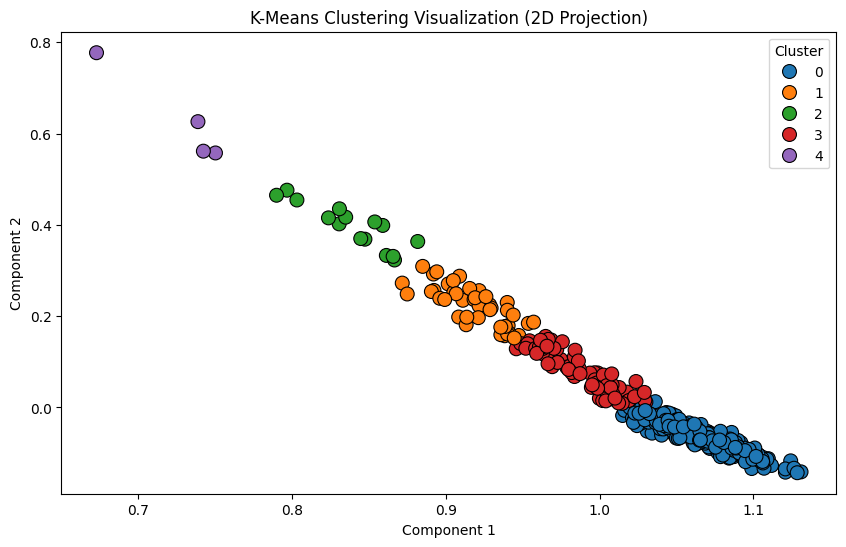

2025-03-09 14:53:33,777 : INFO : collecting all words and their counts
2025-03-09 14:53:33,778 : WARNING : Each 'sentences' item should be a list of words (usually unicode strings). First item here is instead plain <class 'str'>.
2025-03-09 14:53:33,779 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-03-09 14:53:33,783 : INFO : collected 38 word types from a corpus of 24723 raw words and 453 sentences
2025-03-09 14:53:33,785 : INFO : Creating a fresh vocabulary
2025-03-09 14:53:33,786 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 38 unique words (100.00% of original 38, drops 0)', 'datetime': '2025-03-09T14:53:33.786461', 'gensim': '4.3.3', 'python': '3.12.9 (tags/v3.12.9:fdb8142, Feb  4 2025, 15:27:58) [MSC v.1942 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'prepare_vocab'}
2025-03-09 14:53:33,787 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 24723 word corpus (100.00% of origi

Finished displaying at: 2025-03-09 14:53:33 

Finished executing at: 2025-03-09 14:53:33 

Executed at: 2025-03-09 14:53:33 



2025-03-09 14:53:33,994 : INFO : EPOCH 9: training on 24723 raw words (4717 effective words) took 0.0s, 241257 effective words/s
2025-03-09 14:53:34,028 : INFO : EPOCH 10: training on 24723 raw words (4703 effective words) took 0.0s, 300379 effective words/s
2025-03-09 14:53:34,049 : INFO : EPOCH 11: training on 24723 raw words (4792 effective words) took 0.0s, 336692 effective words/s
2025-03-09 14:53:34,078 : INFO : EPOCH 12: training on 24723 raw words (4710 effective words) took 0.0s, 341040 effective words/s
2025-03-09 14:53:34,109 : INFO : EPOCH 13: training on 24723 raw words (4710 effective words) took 0.0s, 295613 effective words/s
2025-03-09 14:53:34,137 : INFO : EPOCH 14: training on 24723 raw words (4720 effective words) took 0.0s, 296921 effective words/s
2025-03-09 14:53:34,163 : INFO : EPOCH 15: training on 24723 raw words (4615 effective words) took 0.0s, 359867 effective words/s
2025-03-09 14:53:34,187 : INFO : EPOCH 16: training on 24723 raw words (4718 effective word

sg=0, Vector_Size=200, Window=3, Epoch=50
Finished displaying at: 2025-03-09 14:53:35 

Executing 5 start time: 2025-03-09 14:53:35
K=5: Silhouette Score and WSS=0.2043	5.1865

Cluster 0:
- Ahmer honored for contributions to squash at K2 Squash Gold Event
- ‘Like a wormhole’: Musk promises ‘Dubai Loop’ tunnel network
- India, US agree to resolve trade and tariff rows after Trump-Modi talks
- TikTok’s Back in the Game! The Viral App Finally Returns to U.S. App Stores!
- ‘Wacky Races’ character designer Jerry Eisenberg dies at 87

Cluster 1:
- Trump says US has approved extradition of suspect in 2008 Mumbai attacks
- Pakistan set 243-run target for New Zealand in Tri-Nation series final
- Togg T10X, Turkey's first national electric SUV
- PFC makes significant impact at 11th IDF
- Top global funds turn to Pakistan as 84% stock rally set to continue: Bloomberg

Cluster 2:
- First Lady of Turkiye visits Maarif International School in Islamabad
- Field of education: Pakistan, Kazakhstan for 

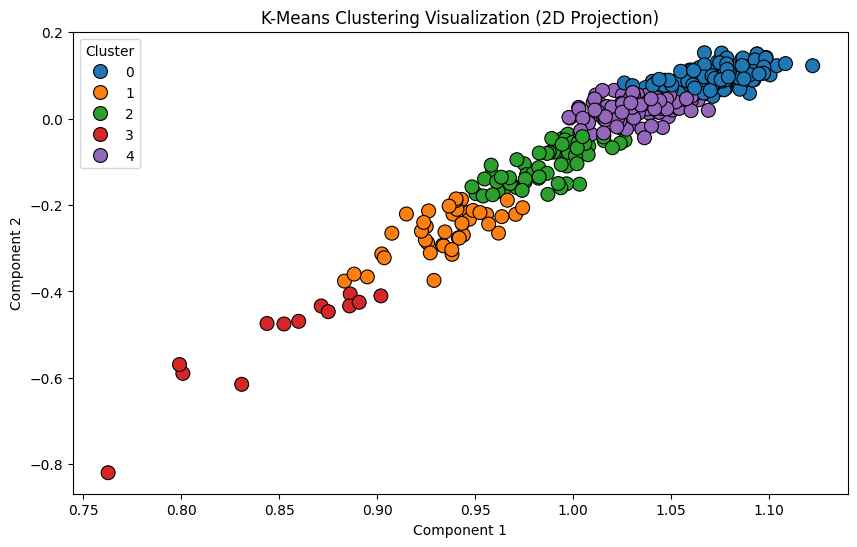

2025-03-09 14:53:35,734 : INFO : collecting all words and their counts
2025-03-09 14:53:35,734 : WARNING : Each 'sentences' item should be a list of words (usually unicode strings). First item here is instead plain <class 'str'>.
2025-03-09 14:53:35,735 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-03-09 14:53:35,742 : INFO : collected 38 word types from a corpus of 24723 raw words and 453 sentences
2025-03-09 14:53:35,743 : INFO : Creating a fresh vocabulary
2025-03-09 14:53:35,744 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 38 unique words (100.00% of original 38, drops 0)', 'datetime': '2025-03-09T14:53:35.744947', 'gensim': '4.3.3', 'python': '3.12.9 (tags/v3.12.9:fdb8142, Feb  4 2025, 15:27:58) [MSC v.1942 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'prepare_vocab'}
2025-03-09 14:53:35,745 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 24723 word corpus (100.00% of origi

Finished displaying at: 2025-03-09 14:53:35 

Finished executing at: 2025-03-09 14:53:35 

Executed at: 2025-03-09 14:53:35 



2025-03-09 14:53:35,925 : INFO : EPOCH 8: training on 24723 raw words (4665 effective words) took 0.0s, 812138 effective words/s
2025-03-09 14:53:35,946 : INFO : EPOCH 9: training on 24723 raw words (4744 effective words) took 0.0s, 541979 effective words/s
2025-03-09 14:53:35,966 : INFO : EPOCH 10: training on 24723 raw words (4690 effective words) took 0.0s, 400126 effective words/s
2025-03-09 14:53:35,986 : INFO : EPOCH 11: training on 24723 raw words (4658 effective words) took 0.0s, 418294 effective words/s
2025-03-09 14:53:36,007 : INFO : EPOCH 12: training on 24723 raw words (4650 effective words) took 0.0s, 408092 effective words/s
2025-03-09 14:53:36,027 : INFO : EPOCH 13: training on 24723 raw words (4677 effective words) took 0.0s, 461643 effective words/s
2025-03-09 14:53:36,045 : INFO : EPOCH 14: training on 24723 raw words (4776 effective words) took 0.0s, 470014 effective words/s
2025-03-09 14:53:36,062 : INFO : EPOCH 15: training on 24723 raw words (4630 effective words

sg=0, Vector_Size=250, Window=3, Epoch=50
Finished displaying at: 2025-03-09 14:53:36 

Executing 5 start time: 2025-03-09 14:53:36
K=5: Silhouette Score and WSS=0.1723	4.7169

Cluster 0:
- Sri Lanka shares end higher; central bank sees inflation peak above target in Q2 next year
- Everyone can’t go to jail to meet Imran: IHC CJ
- US Navy aircraft carrier collides with merchant ship near Egypt, Suez Canal
- Who is Maham Batool? Meet Ahmed Ali Akbar’s bride
- Elon Musk announces Grok 3 AI chatbot launch in the next two weeks

Cluster 1:
- Sean Strickland responds to coach’s harsh criticism of UFC 312 loss
- Maryam says Rs120b allocated for Suthra Punjab Programme
- State Bank of Pakistan’s liquid foreign reserves fall by $252 million
- Pakistan, Turkey set sights on $5b trade
- Key banks implicated in Rs117bn over-invoicing scandal linked to solar panel imports

Cluster 2:
- India’s FX reserves rise to over one-month high on revaluation gains
- Fitness certificate made mandatory for all

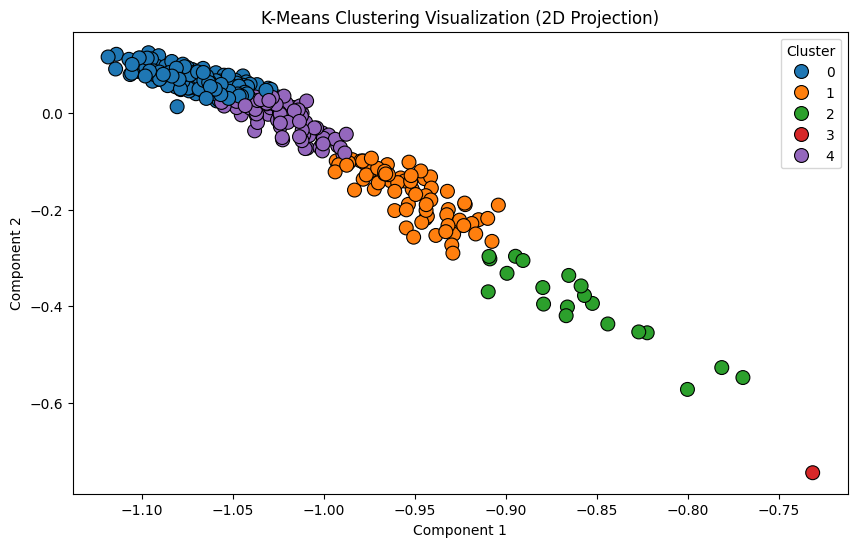

2025-03-09 14:53:37,184 : INFO : collecting all words and their counts
2025-03-09 14:53:37,185 : WARNING : Each 'sentences' item should be a list of words (usually unicode strings). First item here is instead plain <class 'str'>.
2025-03-09 14:53:37,186 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-03-09 14:53:37,193 : INFO : collected 38 word types from a corpus of 24723 raw words and 453 sentences
2025-03-09 14:53:37,195 : INFO : Creating a fresh vocabulary
2025-03-09 14:53:37,197 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 38 unique words (100.00% of original 38, drops 0)', 'datetime': '2025-03-09T14:53:37.197322', 'gensim': '4.3.3', 'python': '3.12.9 (tags/v3.12.9:fdb8142, Feb  4 2025, 15:27:58) [MSC v.1942 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'prepare_vocab'}
2025-03-09 14:53:37,199 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 24723 word corpus (100.00% of origi

Finished displaying at: 2025-03-09 14:53:37 

Finished executing at: 2025-03-09 14:53:37 

Executed at: 2025-03-09 14:53:37 



2025-03-09 14:53:37,380 : INFO : EPOCH 9: training on 24723 raw words (4702 effective words) took 0.0s, 661983 effective words/s
2025-03-09 14:53:37,396 : INFO : EPOCH 10: training on 24723 raw words (4643 effective words) took 0.0s, 502985 effective words/s
2025-03-09 14:53:37,417 : INFO : EPOCH 11: training on 24723 raw words (4622 effective words) took 0.0s, 445082 effective words/s
2025-03-09 14:53:37,437 : INFO : EPOCH 12: training on 24723 raw words (4635 effective words) took 0.0s, 386604 effective words/s
2025-03-09 14:53:37,461 : INFO : EPOCH 13: training on 24723 raw words (4701 effective words) took 0.0s, 672898 effective words/s
2025-03-09 14:53:37,482 : INFO : EPOCH 14: training on 24723 raw words (4701 effective words) took 0.0s, 363745 effective words/s
2025-03-09 14:53:37,503 : INFO : EPOCH 15: training on 24723 raw words (4622 effective words) took 0.0s, 391765 effective words/s
2025-03-09 14:53:37,524 : INFO : EPOCH 16: training on 24723 raw words (4645 effective word

sg=0, Vector_Size=300, Window=3, Epoch=50
Finished displaying at: 2025-03-09 14:53:38 

Executing 5 start time: 2025-03-09 14:53:38
K=5: Silhouette Score and WSS=0.1796	4.9174

Cluster 0:
- Lady Gaga shocked by Sean Evans’ deep-cut questions in Hot Ones teaser
- Playgrounds come alive again with Brazil school phone ban
- Taylor Swift's bodyguard Drew becomes viral sensation for protecting the star
- Yango Pakistan joined hands with Elixs Bikes to introduce affordable EV bikes for partner’s drivers
- Climate change takes centre stage at spring art festival

Cluster 1:
- Islamabad’s Zones 2, 4, and 5: CDA forms joint body to oversee projects
- Pakistan Refinery says will shut down plant for ‘approximately 6 days’
- Bank Alfalah strengthens Qist Bazaar with Rs55m equity and Rs460m credit facility to fuel its expansion
- Wasim Akram joins Meer Group to drive Global Impact Vision 2030
- Pakistan Air Force fighter Jets to kick off ICC Champions Trophy 2025 in Style

Cluster 2:
- Elon Musk an

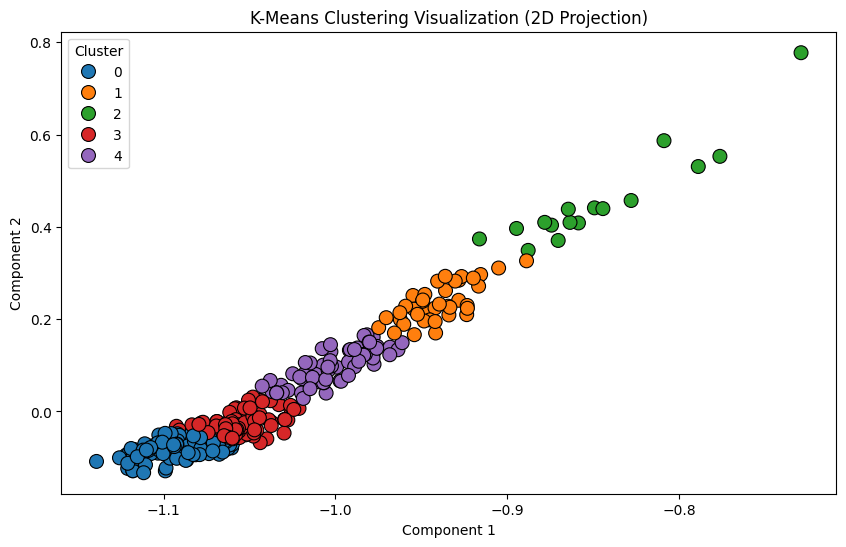

Finished displaying at: 2025-03-09 14:53:38 

Finished executing at: 2025-03-09 14:53:38 



In [114]:
best_combination, best_Sil, best_WSS = run_combinations(5, best_combination, best_Sil, best_WSS)

2025-03-09 14:53:38,593 : INFO : collecting all words and their counts
2025-03-09 14:53:38,596 : WARNING : Each 'sentences' item should be a list of words (usually unicode strings). First item here is instead plain <class 'str'>.
2025-03-09 14:53:38,597 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-03-09 14:53:38,601 : INFO : collected 38 word types from a corpus of 24723 raw words and 453 sentences
2025-03-09 14:53:38,602 : INFO : Creating a fresh vocabulary
2025-03-09 14:53:38,604 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 38 unique words (100.00% of original 38, drops 0)', 'datetime': '2025-03-09T14:53:38.604978', 'gensim': '4.3.3', 'python': '3.12.9 (tags/v3.12.9:fdb8142, Feb  4 2025, 15:27:58) [MSC v.1942 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'prepare_vocab'}
2025-03-09 14:53:38,606 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 24723 word corpus (100.00% of origi

Executed at: 2025-03-09 14:53:38 



2025-03-09 14:53:38,751 : INFO : EPOCH 9: training on 24723 raw words (4603 effective words) took 0.0s, 671226 effective words/s
2025-03-09 14:53:38,765 : INFO : EPOCH 10: training on 24723 raw words (4671 effective words) took 0.0s, 1319529 effective words/s
2025-03-09 14:53:38,776 : INFO : EPOCH 11: training on 24723 raw words (4636 effective words) took 0.0s, 1769196 effective words/s
2025-03-09 14:53:38,789 : INFO : EPOCH 12: training on 24723 raw words (4754 effective words) took 0.0s, 780368 effective words/s
2025-03-09 14:53:38,800 : INFO : EPOCH 13: training on 24723 raw words (4657 effective words) took 0.0s, 790756 effective words/s
2025-03-09 14:53:38,815 : INFO : EPOCH 14: training on 24723 raw words (4574 effective words) took 0.0s, 541212 effective words/s
2025-03-09 14:53:38,828 : INFO : EPOCH 15: training on 24723 raw words (4715 effective words) took 0.0s, 664553 effective words/s
2025-03-09 14:53:38,840 : INFO : EPOCH 16: training on 24723 raw words (4644 effective wo

sg=0, Vector_Size=50, Window=3, Epoch=50
Finished displaying at: 2025-03-09 14:53:39 

Executing 9 start time: 2025-03-09 14:53:39
K=9: Silhouette Score and WSS=0.1268	5.2027

Cluster 0:
- K-P prepares to launch first air ambulance, test flight completed
- Crude Oil prices rebound with slight gain amid US Tariff delay, strong demand
- Pak eye bright future with CT hosting
- Trump launches ‘reciprocal tariffs’ for allies, rivals
- If love hurts, the Sufis say you’re doing it right

Cluster 1:
- Rajat Patidar named RCB captain for IPL 2025 as Virat Kohli gets snubbed
- Solar panel imports: 80 companies transferred around Rs106bn abroad: FBR
- MoITT sets up 43 software tech parks
- Pakistan CPI 2024 – deep-rooted corruption persists
- Trump says US has approved extradition of suspect in 2008 Mumbai attacks

Cluster 2:
- Rawalpindi police arrest primary suspect in college student ‘honour’ killing case
- Seven new judges Join Supreme Court with Oath-Taking Ceremony
- DOGE subcommittee uncov

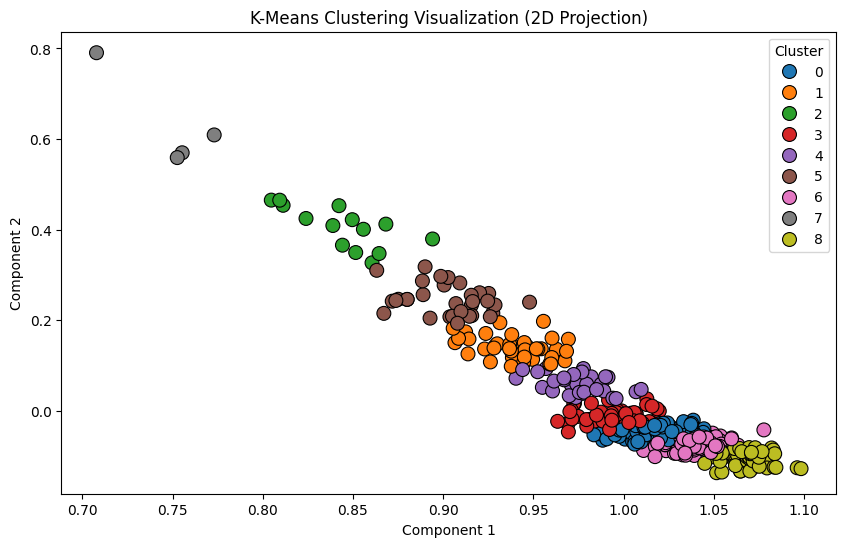

2025-03-09 14:53:39,664 : INFO : collecting all words and their counts
2025-03-09 14:53:39,665 : WARNING : Each 'sentences' item should be a list of words (usually unicode strings). First item here is instead plain <class 'str'>.
2025-03-09 14:53:39,666 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-03-09 14:53:39,671 : INFO : collected 38 word types from a corpus of 24723 raw words and 453 sentences
2025-03-09 14:53:39,672 : INFO : Creating a fresh vocabulary
2025-03-09 14:53:39,673 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 38 unique words (100.00% of original 38, drops 0)', 'datetime': '2025-03-09T14:53:39.673802', 'gensim': '4.3.3', 'python': '3.12.9 (tags/v3.12.9:fdb8142, Feb  4 2025, 15:27:58) [MSC v.1942 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'prepare_vocab'}
2025-03-09 14:53:39,675 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 24723 word corpus (100.00% of origi

Finished displaying at: 2025-03-09 14:53:39 

Finished executing at: 2025-03-09 14:53:39 

Executed at: 2025-03-09 14:53:39 



2025-03-09 14:53:39,879 : INFO : EPOCH 12: training on 24723 raw words (4612 effective words) took 0.0s, 287831 effective words/s
2025-03-09 14:53:39,899 : INFO : EPOCH 13: training on 24723 raw words (4747 effective words) took 0.0s, 501204 effective words/s
2025-03-09 14:53:39,926 : INFO : EPOCH 14: training on 24723 raw words (4690 effective words) took 0.0s, 363206 effective words/s
2025-03-09 14:53:39,949 : INFO : EPOCH 15: training on 24723 raw words (4764 effective words) took 0.0s, 377789 effective words/s
2025-03-09 14:53:39,971 : INFO : EPOCH 16: training on 24723 raw words (4733 effective words) took 0.0s, 367312 effective words/s
2025-03-09 14:53:39,991 : INFO : EPOCH 17: training on 24723 raw words (4583 effective words) took 0.0s, 370682 effective words/s
2025-03-09 14:53:40,012 : INFO : EPOCH 18: training on 24723 raw words (4664 effective words) took 0.0s, 399945 effective words/s
2025-03-09 14:53:40,034 : INFO : EPOCH 19: training on 24723 raw words (4688 effective wor

sg=0, Vector_Size=100, Window=3, Epoch=50
Finished displaying at: 2025-03-09 14:53:40 

Executing 9 start time: 2025-03-09 14:53:40
K=9: Silhouette Score and WSS=0.1257	4.3525

Cluster 0:
- Pakistan keen to increase trade, investment with Japan: Governor
- China’s yuan strengthens as central bank pledges to keep exchange rate stable
- Naqvi inaugurates passport office at NADRA Mega Centre in Karachi’s Nazimabad
- Sharaa speaks of ‘strong strategic ties’ with Russia in Putin phone call
- Afghanistan — the perils of cuddling India

Cluster 1:
- Pakistan CPI 2024 – deep-rooted corruption persists
- More than 500 million take ‘holy dip’ in India’s Maha Kumbh festival
- DS Polo storm into Deepal 96 Punjab Cup final
- Over 500 million devotees take 'holy dip' at Maha Kumbh Mela in India
- Bank Alfalah strengthens Qist Bazaar with Rs55m equity and Rs460m credit facility to fuel its expansion

Cluster 2:
- PM urges Turkish businessmen to invest in diverse fields
- PM vows to advance objective 

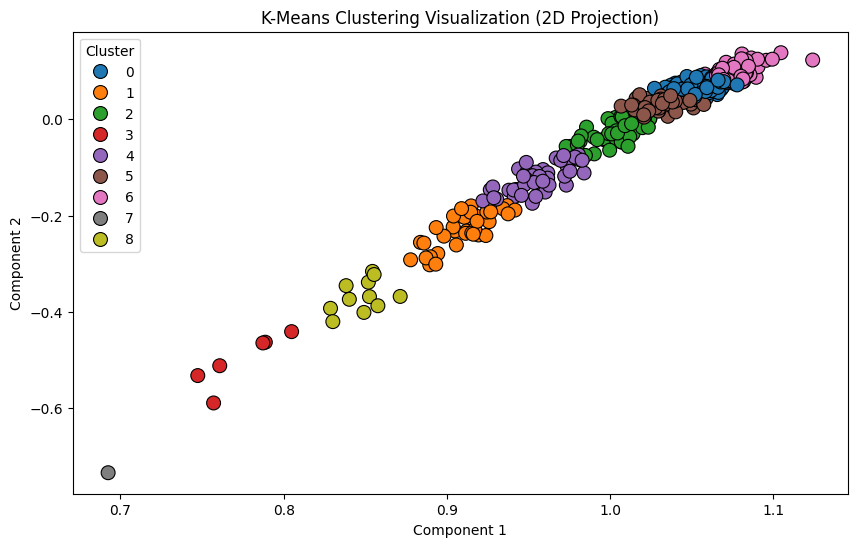

2025-03-09 14:53:40,931 : INFO : collecting all words and their counts
2025-03-09 14:53:40,932 : WARNING : Each 'sentences' item should be a list of words (usually unicode strings). First item here is instead plain <class 'str'>.
2025-03-09 14:53:40,933 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-03-09 14:53:40,936 : INFO : collected 38 word types from a corpus of 24723 raw words and 453 sentences
2025-03-09 14:53:40,937 : INFO : Creating a fresh vocabulary
2025-03-09 14:53:40,939 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 38 unique words (100.00% of original 38, drops 0)', 'datetime': '2025-03-09T14:53:40.939073', 'gensim': '4.3.3', 'python': '3.12.9 (tags/v3.12.9:fdb8142, Feb  4 2025, 15:27:58) [MSC v.1942 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'prepare_vocab'}
2025-03-09 14:53:40,940 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 24723 word corpus (100.00% of origi

Finished displaying at: 2025-03-09 14:53:40 

Finished executing at: 2025-03-09 14:53:40 

Executed at: 2025-03-09 14:53:40 



2025-03-09 14:53:41,120 : INFO : EPOCH 12: training on 24723 raw words (4594 effective words) took 0.0s, 676643 effective words/s
2025-03-09 14:53:41,135 : INFO : EPOCH 13: training on 24723 raw words (4741 effective words) took 0.0s, 573069 effective words/s
2025-03-09 14:53:41,149 : INFO : EPOCH 14: training on 24723 raw words (4612 effective words) took 0.0s, 648008 effective words/s
2025-03-09 14:53:41,162 : INFO : EPOCH 15: training on 24723 raw words (4634 effective words) took 0.0s, 2799493 effective words/s
2025-03-09 14:53:41,174 : INFO : EPOCH 16: training on 24723 raw words (4674 effective words) took 0.0s, 619007 effective words/s
2025-03-09 14:53:41,188 : INFO : EPOCH 17: training on 24723 raw words (4612 effective words) took 0.0s, 551404 effective words/s
2025-03-09 14:53:41,200 : INFO : EPOCH 18: training on 24723 raw words (4606 effective words) took 0.0s, 672320 effective words/s
2025-03-09 14:53:41,212 : INFO : EPOCH 19: training on 24723 raw words (4655 effective wo

sg=0, Vector_Size=150, Window=3, Epoch=50
Finished displaying at: 2025-03-09 14:53:41 

Executing 9 start time: 2025-03-09 14:53:41
K=9: Silhouette Score and WSS=0.1387	4.3577

Cluster 0:
- Drake surprises Melbourne fan with on-stage gender reveal & gifts $50K to expectant mother
- This Valentine's Day, say yes to socks and no to flowers
- CJP Afridi administers oath to newly-appointed SC judges
- Prince William and Kate Middleton celebrate Valentine's Day sharing PDA-filled photo
- Gold prices see another rise to reach record highs in Pakistan

Cluster 1:
- Solar panel imports: 80 companies transferred around Rs106bn abroad: FBR
- FPSC issues latest public notice regarding CSS Exams 2025
- From The Past Pages Of Dawn: 1975: Fifty Years Ago: Secret deal denounced
- BISE Rawalpindi 10th Class Roll Number Slips 2025 for private students update
- India seen seeking global bids this year for 114 fighters

Cluster 2:
- Aurangzeb highlights increasing risks facing insurance industry
- Austra

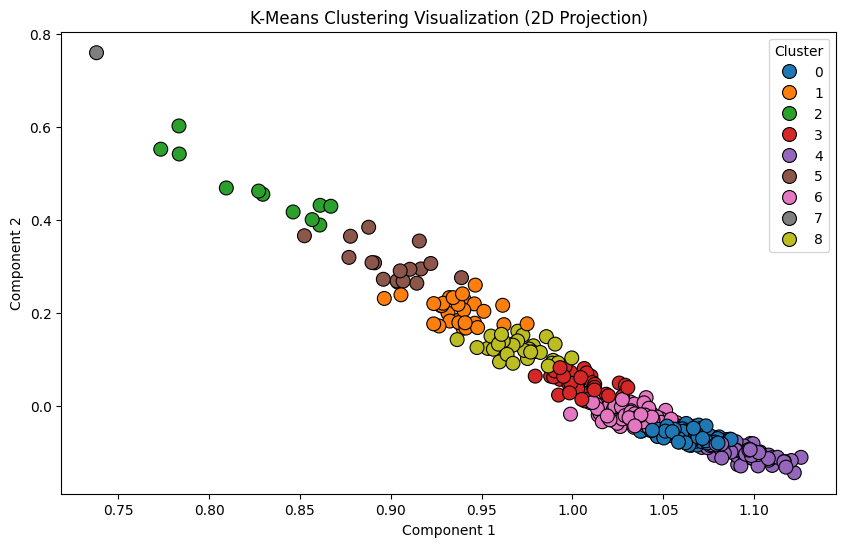

2025-03-09 14:53:42,048 : INFO : collecting all words and their counts
2025-03-09 14:53:42,049 : WARNING : Each 'sentences' item should be a list of words (usually unicode strings). First item here is instead plain <class 'str'>.
2025-03-09 14:53:42,050 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-03-09 14:53:42,058 : INFO : collected 38 word types from a corpus of 24723 raw words and 453 sentences
2025-03-09 14:53:42,067 : INFO : Creating a fresh vocabulary
2025-03-09 14:53:42,070 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 38 unique words (100.00% of original 38, drops 0)', 'datetime': '2025-03-09T14:53:42.070998', 'gensim': '4.3.3', 'python': '3.12.9 (tags/v3.12.9:fdb8142, Feb  4 2025, 15:27:58) [MSC v.1942 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'prepare_vocab'}
2025-03-09 14:53:42,072 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 24723 word corpus (100.00% of origi

Finished displaying at: 2025-03-09 14:53:42 

Finished executing at: 2025-03-09 14:53:42 

Executed at: 2025-03-09 14:53:42 



2025-03-09 14:53:42,273 : INFO : EPOCH 5: training on 24723 raw words (4657 effective words) took 0.0s, 515965 effective words/s
2025-03-09 14:53:42,288 : INFO : EPOCH 6: training on 24723 raw words (4720 effective words) took 0.0s, 937289 effective words/s
2025-03-09 14:53:42,308 : INFO : EPOCH 7: training on 24723 raw words (4694 effective words) took 0.0s, 487688 effective words/s
2025-03-09 14:53:42,327 : INFO : EPOCH 8: training on 24723 raw words (4702 effective words) took 0.0s, 426787 effective words/s
2025-03-09 14:53:42,345 : INFO : EPOCH 9: training on 24723 raw words (4683 effective words) took 0.0s, 453704 effective words/s
2025-03-09 14:53:42,362 : INFO : EPOCH 10: training on 24723 raw words (4664 effective words) took 0.0s, 498610 effective words/s
2025-03-09 14:53:42,381 : INFO : EPOCH 11: training on 24723 raw words (4603 effective words) took 0.0s, 434471 effective words/s
2025-03-09 14:53:42,397 : INFO : EPOCH 12: training on 24723 raw words (4716 effective words) t

sg=0, Vector_Size=200, Window=3, Epoch=50
Finished displaying at: 2025-03-09 14:53:43 

Executing 9 start time: 2025-03-09 14:53:43
K=9: Silhouette Score and WSS=0.1401	3.8660

Cluster 0:
- Senate pays rich tributes to Prince Karim Aga Khan
- Saudi Arabia to host Arab summit on Trump’s Gaza plan
- 'Qubool Hai:' Kubra Khan and Gohar Rasheed Have Tied the Knot in Makkah
- Ahmed Ali Akbar and Maham Batool Kickstart Their Wedding with a Qawwali Night
- Australia’s Johnson sees chance to shine while ‘Big Three’ quicks away

Cluster 1:
- BISE Rawalpindi 10th Class Roll Number Slips 2025 for private students update
- India seen seeking global bids this year for 114 fighters
- ICC announces prize money for 2025 Champions Trophy
- CSS 2025 exam to begin as scheduled after IHC dismisses postponement plea
- SBP reserves fall $500m in less than a month | Dawn News English

Cluster 2:
- Artists asked to submit their entries for exhibition till March 20
- Page World Economy and Politics News ISB Pag

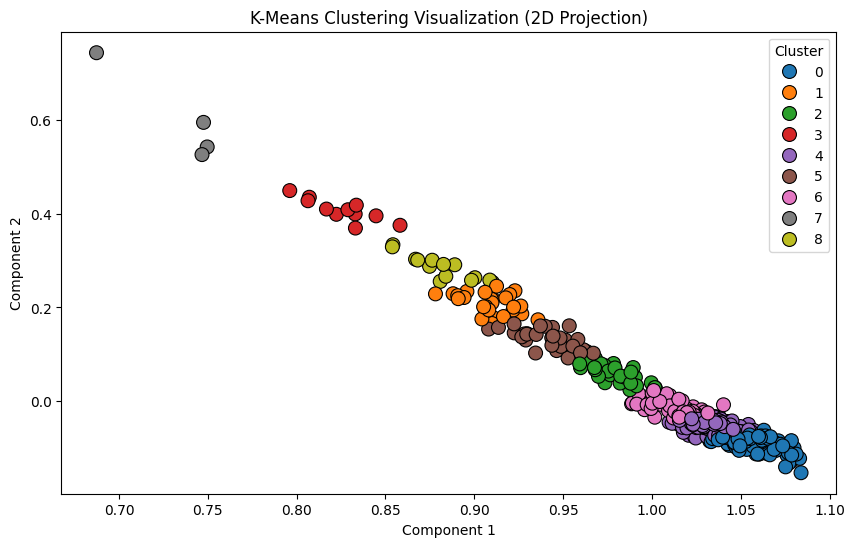

2025-03-09 14:53:43,399 : INFO : collecting all words and their counts
2025-03-09 14:53:43,399 : WARNING : Each 'sentences' item should be a list of words (usually unicode strings). First item here is instead plain <class 'str'>.
2025-03-09 14:53:43,400 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-03-09 14:53:43,404 : INFO : collected 38 word types from a corpus of 24723 raw words and 453 sentences
2025-03-09 14:53:43,405 : INFO : Creating a fresh vocabulary
2025-03-09 14:53:43,407 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 38 unique words (100.00% of original 38, drops 0)', 'datetime': '2025-03-09T14:53:43.406750', 'gensim': '4.3.3', 'python': '3.12.9 (tags/v3.12.9:fdb8142, Feb  4 2025, 15:27:58) [MSC v.1942 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'prepare_vocab'}
2025-03-09 14:53:43,408 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 24723 word corpus (100.00% of origi

Finished displaying at: 2025-03-09 14:53:43 

Finished executing at: 2025-03-09 14:53:43 

Executed at: 2025-03-09 14:53:43 



2025-03-09 14:53:43,589 : INFO : EPOCH 11: training on 24723 raw words (4740 effective words) took 0.0s, 602081 effective words/s
2025-03-09 14:53:43,605 : INFO : EPOCH 12: training on 24723 raw words (4737 effective words) took 0.0s, 680985 effective words/s
2025-03-09 14:53:43,618 : INFO : EPOCH 13: training on 24723 raw words (4661 effective words) took 0.0s, 1060306 effective words/s
2025-03-09 14:53:43,635 : INFO : EPOCH 14: training on 24723 raw words (4778 effective words) took 0.0s, 443483 effective words/s
2025-03-09 14:53:43,652 : INFO : EPOCH 15: training on 24723 raw words (4685 effective words) took 0.0s, 422460 effective words/s
2025-03-09 14:53:43,668 : INFO : EPOCH 16: training on 24723 raw words (4688 effective words) took 0.0s, 510014 effective words/s
2025-03-09 14:53:43,683 : INFO : EPOCH 17: training on 24723 raw words (4665 effective words) took 0.0s, 541611 effective words/s
2025-03-09 14:53:43,719 : INFO : EPOCH 18: training on 24723 raw words (4683 effective wo

sg=0, Vector_Size=250, Window=3, Epoch=50
Finished displaying at: 2025-03-09 14:53:44 

Executing 9 start time: 2025-03-09 14:53:44
K=9: Silhouette Score and WSS=0.1562	3.4684

Cluster 0:
- PIA upbeat about resumption of UK flights
- PM vows to advance objective of combating climate change
- CJP Afridi administers oath to newly-appointed SC judges
- "Not my King': Anti-monarchy protesters chant at King Charles during visit to Middlesbrough
- CJP Yahya Afridi administers oath to six newly appointed SC judges

Cluster 1:
- Railways to restore Shah Hussain Express from 25th
- Sri Lanka hammer Australia in record 174-run rout
- Rs10bn defamation suit: LHC seeks more arguments on IK’s plea
- Salaried class tax payments surge to Rs285bn in seven months, minister hints at relief
- Druski roasted by NBA fans for bold 2025 All-Star game stat predictions and lack of defense

Cluster 2:
- Pakistan’s 2nd polio case of 2025 reported in Badin
- Stocks remain range-bound, KSE-100 closes 361 points lo

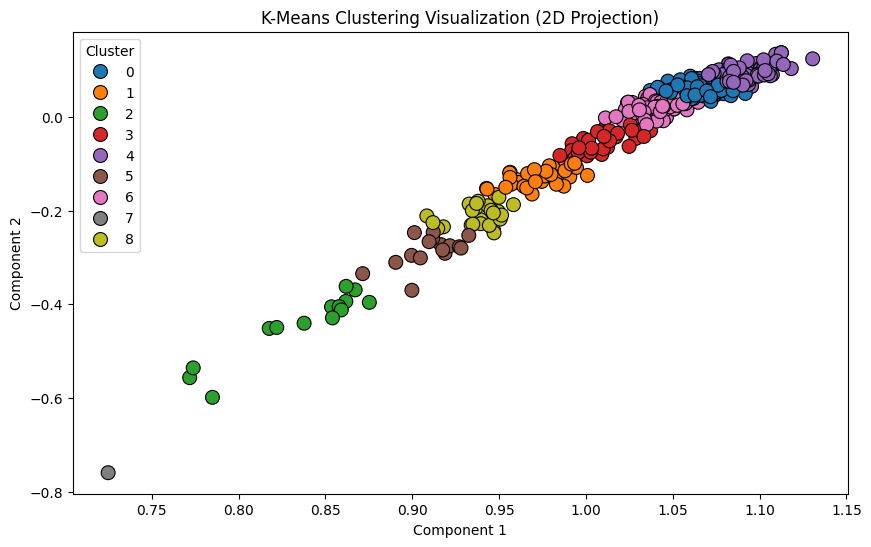

2025-03-09 14:53:44,695 : INFO : collecting all words and their counts
2025-03-09 14:53:44,696 : WARNING : Each 'sentences' item should be a list of words (usually unicode strings). First item here is instead plain <class 'str'>.
2025-03-09 14:53:44,697 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-03-09 14:53:44,702 : INFO : collected 38 word types from a corpus of 24723 raw words and 453 sentences
2025-03-09 14:53:44,703 : INFO : Creating a fresh vocabulary
2025-03-09 14:53:44,705 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 38 unique words (100.00% of original 38, drops 0)', 'datetime': '2025-03-09T14:53:44.705601', 'gensim': '4.3.3', 'python': '3.12.9 (tags/v3.12.9:fdb8142, Feb  4 2025, 15:27:58) [MSC v.1942 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'prepare_vocab'}
2025-03-09 14:53:44,705 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 24723 word corpus (100.00% of origi

Finished displaying at: 2025-03-09 14:53:44 

Finished executing at: 2025-03-09 14:53:44 

Executed at: 2025-03-09 14:53:44 



2025-03-09 14:53:44,883 : INFO : EPOCH 11: training on 24723 raw words (4736 effective words) took 0.0s, 567254 effective words/s
2025-03-09 14:53:44,897 : INFO : EPOCH 12: training on 24723 raw words (4788 effective words) took 0.0s, 597440 effective words/s
2025-03-09 14:53:44,914 : INFO : EPOCH 13: training on 24723 raw words (4674 effective words) took 0.0s, 489071 effective words/s
2025-03-09 14:53:44,928 : INFO : EPOCH 14: training on 24723 raw words (4789 effective words) took 0.0s, 593153 effective words/s
2025-03-09 14:53:44,943 : INFO : EPOCH 15: training on 24723 raw words (4695 effective words) took 0.0s, 496647 effective words/s
2025-03-09 14:53:44,956 : INFO : EPOCH 16: training on 24723 raw words (4665 effective words) took 0.0s, 594328 effective words/s
2025-03-09 14:53:44,972 : INFO : EPOCH 17: training on 24723 raw words (4761 effective words) took 0.0s, 549471 effective words/s
2025-03-09 14:53:44,986 : INFO : EPOCH 18: training on 24723 raw words (4732 effective wor

sg=0, Vector_Size=300, Window=3, Epoch=50
Finished displaying at: 2025-03-09 14:53:45 

Executing 9 start time: 2025-03-09 14:53:45
K=9: Silhouette Score and WSS=0.1525	3.6574

Cluster 0:
- Senate pays rich tributes to Prince Karim Aga Khan
- Former SC judge Sheikh Azmat Saeed’s funeral to be held today
- KU VC Prof Dr Khalid Iraqi inaugurates second agricultural festival
- Turkish President Erdogan reaches PM House for talks with Shehbaz Sharif
- Saudi Arabia to host Arab summit on Trump’s Gaza plan

Cluster 1:
- MoITT sets up 43 software tech parks
- Pakistan Software Export Board expands IT infrastructure with 43 technology parks
- AsiaPak, Montage Oil bid for 75% of Lotte Chemical
- Page World Economy and Politics News Page 5
- ‘Wacky Races’ character designer Jerry Eisenberg dies at 87

Cluster 2:
- Over 16,000 School Teacher Jobs 2025 – Here’s all you need to know
- Gold price soars by Rs2,500 per tola

Cluster 3:
- Pakistan, Turkiye sign multiple agreements to strengthen bilater

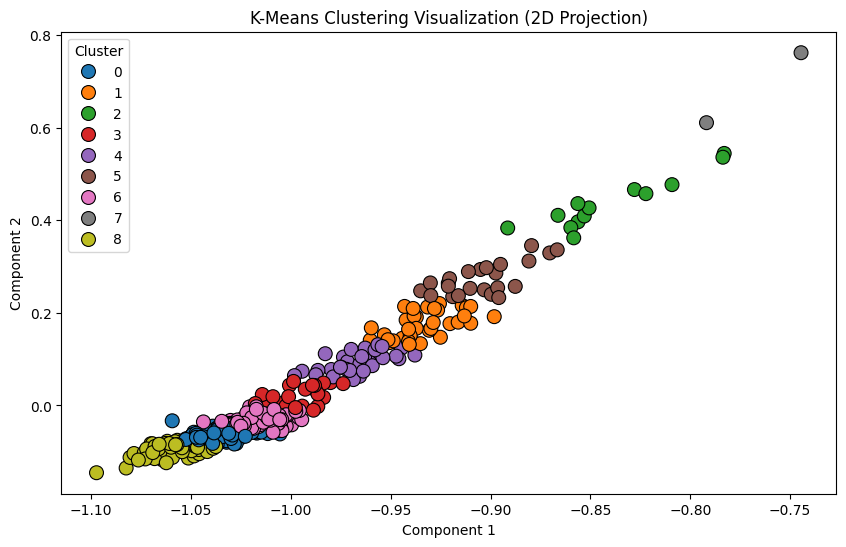

Finished displaying at: 2025-03-09 14:53:45 

Finished executing at: 2025-03-09 14:53:45 



In [115]:
best_combination, best_Sil, best_WSS = run_combinations(9, best_combination, best_Sil, best_WSS)

2025-03-09 14:53:45,969 : INFO : collecting all words and their counts
2025-03-09 14:53:45,971 : WARNING : Each 'sentences' item should be a list of words (usually unicode strings). First item here is instead plain <class 'str'>.
2025-03-09 14:53:45,972 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-03-09 14:53:45,975 : INFO : collected 38 word types from a corpus of 24723 raw words and 453 sentences
2025-03-09 14:53:45,977 : INFO : Creating a fresh vocabulary
2025-03-09 14:53:45,978 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 38 unique words (100.00% of original 38, drops 0)', 'datetime': '2025-03-09T14:53:45.978203', 'gensim': '4.3.3', 'python': '3.12.9 (tags/v3.12.9:fdb8142, Feb  4 2025, 15:27:58) [MSC v.1942 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'prepare_vocab'}
2025-03-09 14:53:45,980 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 24723 word corpus (100.00% of origi

Executed at: 2025-03-09 14:53:45 



2025-03-09 14:53:46,154 : INFO : EPOCH 12: training on 24723 raw words (4674 effective words) took 0.0s, 772920 effective words/s
2025-03-09 14:53:46,168 : INFO : EPOCH 13: training on 24723 raw words (4685 effective words) took 0.0s, 822088 effective words/s
2025-03-09 14:53:46,181 : INFO : EPOCH 14: training on 24723 raw words (4629 effective words) took 0.0s, 683328 effective words/s
2025-03-09 14:53:46,195 : INFO : EPOCH 15: training on 24723 raw words (4703 effective words) took 0.0s, 683566 effective words/s
2025-03-09 14:53:46,208 : INFO : EPOCH 16: training on 24723 raw words (4620 effective words) took 0.0s, 629445 effective words/s
2025-03-09 14:53:46,220 : INFO : EPOCH 17: training on 24723 raw words (4709 effective words) took 0.0s, 833687 effective words/s
2025-03-09 14:53:46,230 : INFO : EPOCH 18: training on 24723 raw words (4646 effective words) took 0.0s, 835356 effective words/s
2025-03-09 14:53:46,242 : INFO : EPOCH 19: training on 24723 raw words (4609 effective wor

sg=0, Vector_Size=50, Window=3, Epoch=50
Finished displaying at: 2025-03-09 14:53:46 

Executing 13 start time: 2025-03-09 14:53:46
K=13: Silhouette Score and WSS=0.1120	5.1820

Cluster 0:
- Justice Sarfraz Dogar takes oath as acting Chief Justice of IHC
- Aurangzeb discusses Pakistan’s structural reforms with IFC chief
- South African rand firms after Trump’s tariff move; local budget next week
- IGP pays tributes to police martyrs of Faisal Chowk Mall Road tragedy
- Senate pays rich tributes to Prince Karim Aga Khan

Cluster 1:
- Sri Lanka hammer Australia in record 174-run rout
- Bank Alfalah strengthens Qist Bazaar with Rs55m equity and Rs460m credit facility to fuel its expansion
- Druski roasted by NBA fans for bold 2025 All-Star game stat predictions and lack of defense
- Saudi Arabia confirms alcohol ban at 2034 FIFA World Cup
- Umair Jaswal, Hadiqa Kiani, and Shae Gill to headline Lahooti 2025

Cluster 2:
- Polio certificate must for Saudi-bound passengers: PIA
- PPL executes 

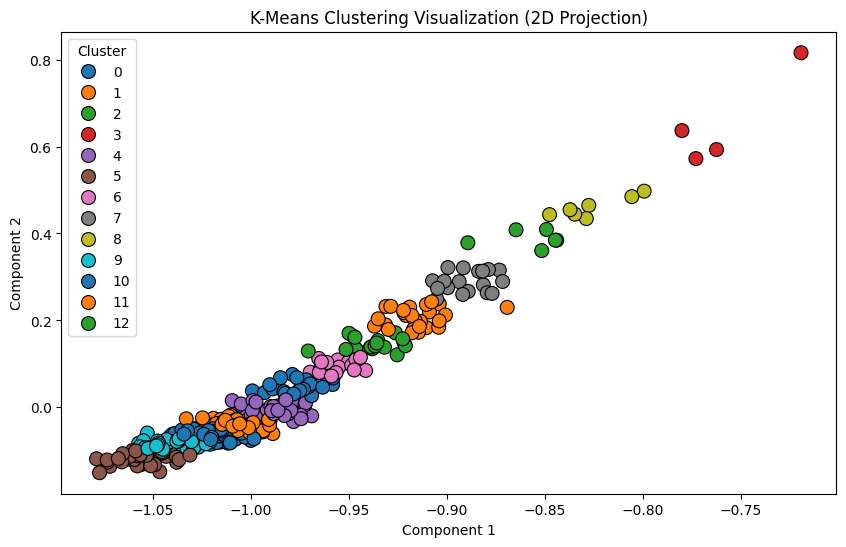

2025-03-09 14:53:47,078 : INFO : collecting all words and their counts
2025-03-09 14:53:47,079 : WARNING : Each 'sentences' item should be a list of words (usually unicode strings). First item here is instead plain <class 'str'>.
2025-03-09 14:53:47,080 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-03-09 14:53:47,086 : INFO : collected 38 word types from a corpus of 24723 raw words and 453 sentences
2025-03-09 14:53:47,087 : INFO : Creating a fresh vocabulary
2025-03-09 14:53:47,088 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 38 unique words (100.00% of original 38, drops 0)', 'datetime': '2025-03-09T14:53:47.088844', 'gensim': '4.3.3', 'python': '3.12.9 (tags/v3.12.9:fdb8142, Feb  4 2025, 15:27:58) [MSC v.1942 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'prepare_vocab'}
2025-03-09 14:53:47,089 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 24723 word corpus (100.00% of origi

Finished displaying at: 2025-03-09 14:53:47 

Finished executing at: 2025-03-09 14:53:47 

Executed at: 2025-03-09 14:53:47 



2025-03-09 14:53:47,266 : INFO : EPOCH 6: training on 24723 raw words (4751 effective words) took 0.0s, 485936 effective words/s
2025-03-09 14:53:47,283 : INFO : EPOCH 7: training on 24723 raw words (4661 effective words) took 0.0s, 548134 effective words/s
2025-03-09 14:53:47,307 : INFO : EPOCH 8: training on 24723 raw words (4778 effective words) took 0.0s, 347279 effective words/s
2025-03-09 14:53:47,329 : INFO : EPOCH 9: training on 24723 raw words (4670 effective words) took 0.0s, 432099 effective words/s
2025-03-09 14:53:47,348 : INFO : EPOCH 10: training on 24723 raw words (4719 effective words) took 0.0s, 1077840 effective words/s
2025-03-09 14:53:47,373 : INFO : EPOCH 11: training on 24723 raw words (4655 effective words) took 0.0s, 377360 effective words/s
2025-03-09 14:53:47,392 : INFO : EPOCH 12: training on 24723 raw words (4603 effective words) took 0.0s, 708263 effective words/s
2025-03-09 14:53:47,416 : INFO : EPOCH 13: training on 24723 raw words (4575 effective words)

sg=0, Vector_Size=100, Window=3, Epoch=50
Finished displaying at: 2025-03-09 14:53:48 

Executing 13 start time: 2025-03-09 14:53:48
K=13: Silhouette Score and WSS=0.1121	4.5582

Cluster 0:
- Credits against tax WH: FBR issuing notices to salaried individuals: KTBA
- Kuwait hosts high-level forum to discuss International Islamic Court of Justice
- PM thanks President Erdogan for visiting Pakistan
- Customs officials, chamber president kidnapped in K-P
- CJP Afridi administers oath to newly-appointed SC judges

Cluster 1:
- BISE Rawalpindi 10th Class Roll Number Slips 2025 for private students update
- India seen seeking global bids this year for 114 fighters
- Journalist killings reach record high in 2024
- PSX witnesses bearish trend, loses 360 points
- SBP reserves fall $500m in less than a month | Dawn News English

Cluster 2:
- Afghanistan — the perils of cuddling India
- Australia thrashed as Sri Lanka sweep ODI series
- The Ultimate Guide to Healing Foods: Eat Your Way to Better 

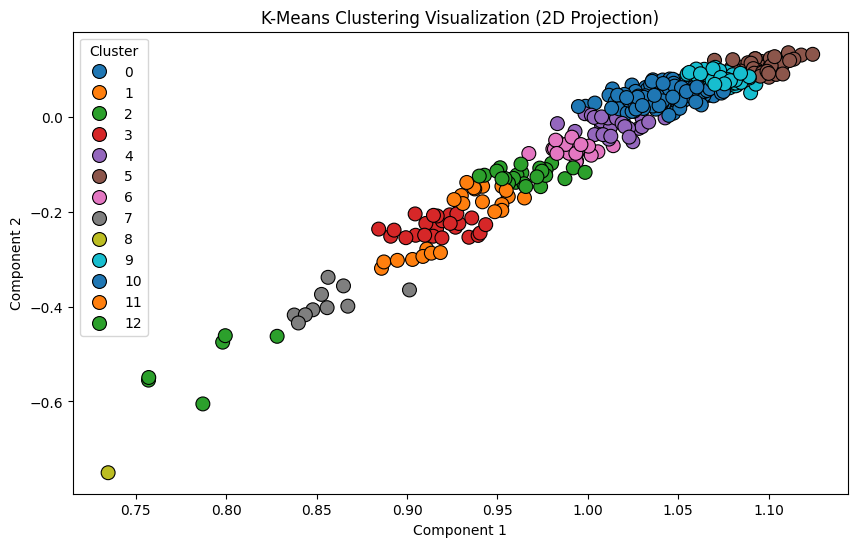

2025-03-09 14:53:49,287 : INFO : collecting all words and their counts
2025-03-09 14:53:49,288 : WARNING : Each 'sentences' item should be a list of words (usually unicode strings). First item here is instead plain <class 'str'>.
2025-03-09 14:53:49,289 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-03-09 14:53:49,291 : INFO : collected 38 word types from a corpus of 24723 raw words and 453 sentences
2025-03-09 14:53:49,295 : INFO : Creating a fresh vocabulary
2025-03-09 14:53:49,297 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 38 unique words (100.00% of original 38, drops 0)', 'datetime': '2025-03-09T14:53:49.297025', 'gensim': '4.3.3', 'python': '3.12.9 (tags/v3.12.9:fdb8142, Feb  4 2025, 15:27:58) [MSC v.1942 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'prepare_vocab'}
2025-03-09 14:53:49,298 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 24723 word corpus (100.00% of origi

Finished displaying at: 2025-03-09 14:53:49 

Finished executing at: 2025-03-09 14:53:49 

Executed at: 2025-03-09 14:53:49 



2025-03-09 14:53:49,489 : INFO : EPOCH 8: training on 24723 raw words (4610 effective words) took 0.0s, 290850 effective words/s
2025-03-09 14:53:49,508 : INFO : EPOCH 9: training on 24723 raw words (4674 effective words) took 0.0s, 482154 effective words/s
2025-03-09 14:53:49,538 : INFO : EPOCH 10: training on 24723 raw words (4640 effective words) took 0.0s, 421217 effective words/s
2025-03-09 14:53:49,557 : INFO : EPOCH 11: training on 24723 raw words (4687 effective words) took 0.0s, 388779 effective words/s
2025-03-09 14:53:49,572 : INFO : EPOCH 12: training on 24723 raw words (4556 effective words) took 0.0s, 549929 effective words/s
2025-03-09 14:53:49,588 : INFO : EPOCH 13: training on 24723 raw words (4726 effective words) took 0.0s, 485410 effective words/s
2025-03-09 14:53:49,604 : INFO : EPOCH 14: training on 24723 raw words (4563 effective words) took 0.0s, 558370 effective words/s
2025-03-09 14:53:49,625 : INFO : EPOCH 15: training on 24723 raw words (4694 effective words

sg=0, Vector_Size=150, Window=3, Epoch=50
Finished displaying at: 2025-03-09 14:53:50 

Executing 13 start time: 2025-03-09 14:53:50
K=13: Silhouette Score and WSS=0.1304	3.5164

Cluster 0:
- Hasan Raheem softens down his song 'Obvious'
- IGP pays tributes to police martyrs of Faisal Chowk Mall Road tragedy
- PlayStation state of play returns with new games, trailers, and updates
- ‘Is this the same team?’: Cricket fans rejoice as Pakistan clinches record-breaking victory against South Africa
- Alligators, raccoons, and more thrive in urban sewer systems

Cluster 1:
- Pakistan Air Force fighter Jets to kick off ICC Champions Trophy 2025 in Style
- India expects $200 million missile deal with Philippines this year, sources say
- Kanye West's $250K sex tape scandal resurfaces amid Bianca Censori divorce rumors
- Petrol Price in Pakistan to ‘go down’ from Feb 16 amid dip in global oil rates
- Pakistan Foreign Policy Challenges: Post US Presidential Election 2024

Cluster 2:
- Over 16,000 

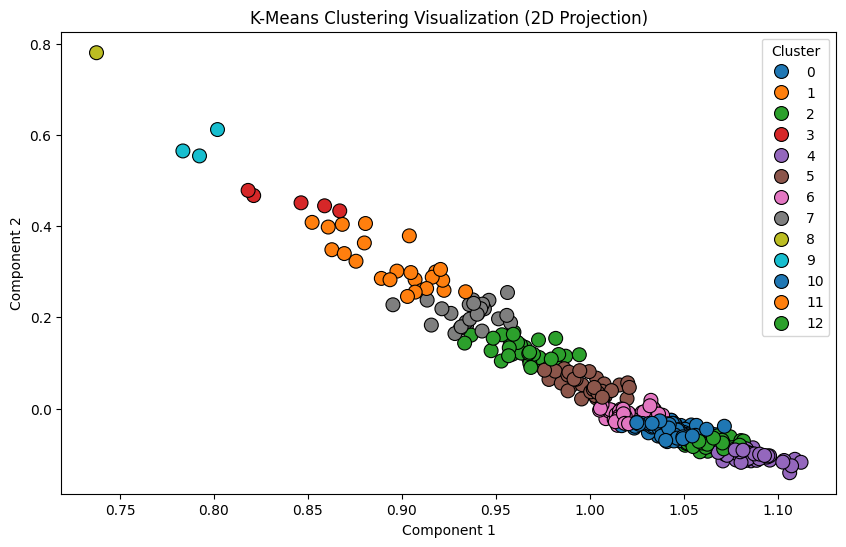

2025-03-09 14:53:51,188 : INFO : collecting all words and their counts
2025-03-09 14:53:51,189 : WARNING : Each 'sentences' item should be a list of words (usually unicode strings). First item here is instead plain <class 'str'>.
2025-03-09 14:53:51,190 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-03-09 14:53:51,196 : INFO : collected 38 word types from a corpus of 24723 raw words and 453 sentences
2025-03-09 14:53:51,197 : INFO : Creating a fresh vocabulary
2025-03-09 14:53:51,198 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 38 unique words (100.00% of original 38, drops 0)', 'datetime': '2025-03-09T14:53:51.198865', 'gensim': '4.3.3', 'python': '3.12.9 (tags/v3.12.9:fdb8142, Feb  4 2025, 15:27:58) [MSC v.1942 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'prepare_vocab'}
2025-03-09 14:53:51,200 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 24723 word corpus (100.00% of origi

Finished displaying at: 2025-03-09 14:53:51 

Finished executing at: 2025-03-09 14:53:51 

Executed at: 2025-03-09 14:53:51 



2025-03-09 14:53:51,377 : INFO : EPOCH 3: training on 24723 raw words (4770 effective words) took 0.0s, 226608 effective words/s
2025-03-09 14:53:51,415 : INFO : EPOCH 4: training on 24723 raw words (4603 effective words) took 0.0s, 397798 effective words/s
2025-03-09 14:53:51,449 : INFO : EPOCH 5: training on 24723 raw words (4685 effective words) took 0.0s, 241525 effective words/s
2025-03-09 14:53:51,483 : INFO : EPOCH 6: training on 24723 raw words (4698 effective words) took 0.0s, 244989 effective words/s
2025-03-09 14:53:51,511 : INFO : EPOCH 7: training on 24723 raw words (4677 effective words) took 0.0s, 281951 effective words/s
2025-03-09 14:53:51,544 : INFO : EPOCH 8: training on 24723 raw words (4679 effective words) took 0.0s, 254591 effective words/s
2025-03-09 14:53:51,576 : INFO : EPOCH 9: training on 24723 raw words (4704 effective words) took 0.0s, 251314 effective words/s
2025-03-09 14:53:51,610 : INFO : EPOCH 10: training on 24723 raw words (4649 effective words) too

sg=0, Vector_Size=200, Window=3, Epoch=50
Finished displaying at: 2025-03-09 14:53:52 

Executing 13 start time: 2025-03-09 14:53:52
K=13: Silhouette Score and WSS=0.1307	3.1578

Cluster 0:
- From Napa to Rada: Actor Hani Taha’s journey to the world’s premier drama school
- Cabinet approves civil servants’ asset declaration law under IMF reform agenda
- PM vows to advance objective of combating climate change
- Climate change takes centre stage at spring art festival
- JD Vance says US wields economic, military leverage on Russia in Ukraine talks

Cluster 1:
- Page World Economy and Politics News Page 5
- US, India strike deal for F-35 stealth fighter jets amid growing defense ties
- 26 Year-Old TikToker Bailey Hutchins Tragically Passes Away After 2 Year Battle With Colon Cancer
- Petrol Price in Pakistan to ‘go down’ from Feb 16 amid dip in global oil rates
- India expects $200 million missile deal with Philippines this year, sources say

Cluster 2:
- Pakistan’s 2nd polio case of 202

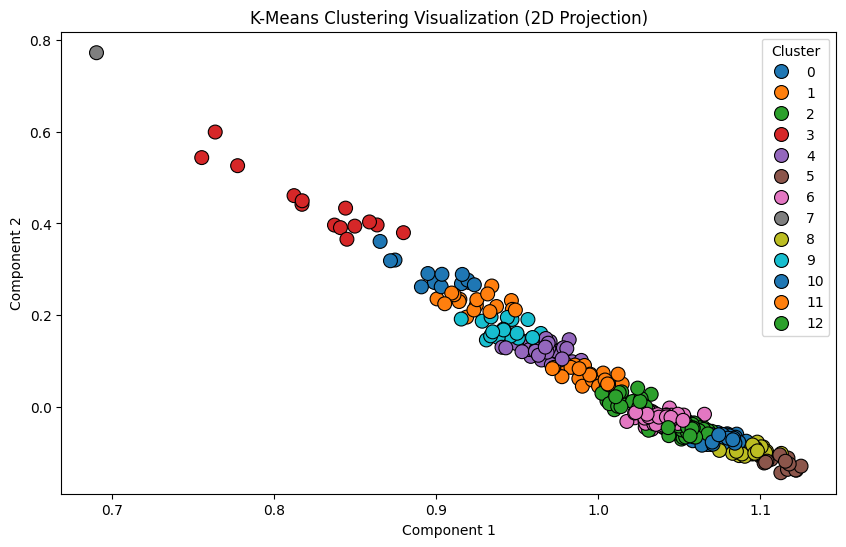

2025-03-09 14:53:52,827 : INFO : collecting all words and their counts
2025-03-09 14:53:52,828 : WARNING : Each 'sentences' item should be a list of words (usually unicode strings). First item here is instead plain <class 'str'>.
2025-03-09 14:53:52,829 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-03-09 14:53:52,834 : INFO : collected 38 word types from a corpus of 24723 raw words and 453 sentences
2025-03-09 14:53:52,835 : INFO : Creating a fresh vocabulary
2025-03-09 14:53:52,836 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 38 unique words (100.00% of original 38, drops 0)', 'datetime': '2025-03-09T14:53:52.836565', 'gensim': '4.3.3', 'python': '3.12.9 (tags/v3.12.9:fdb8142, Feb  4 2025, 15:27:58) [MSC v.1942 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'prepare_vocab'}
2025-03-09 14:53:52,837 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 24723 word corpus (100.00% of origi

Finished displaying at: 2025-03-09 14:53:52 

Finished executing at: 2025-03-09 14:53:52 

Executed at: 2025-03-09 14:53:52 



2025-03-09 14:53:53,038 : INFO : EPOCH 11: training on 24723 raw words (4698 effective words) took 0.0s, 552251 effective words/s
2025-03-09 14:53:53,053 : INFO : EPOCH 12: training on 24723 raw words (4716 effective words) took 0.0s, 564371 effective words/s
2025-03-09 14:53:53,071 : INFO : EPOCH 13: training on 24723 raw words (4697 effective words) took 0.0s, 453400 effective words/s
2025-03-09 14:53:53,085 : INFO : EPOCH 14: training on 24723 raw words (4563 effective words) took 0.0s, 552957 effective words/s
2025-03-09 14:53:53,099 : INFO : EPOCH 15: training on 24723 raw words (4660 effective words) took 0.0s, 1662030 effective words/s
2025-03-09 14:53:53,113 : INFO : EPOCH 16: training on 24723 raw words (4661 effective words) took 0.0s, 566123 effective words/s
2025-03-09 14:53:53,128 : INFO : EPOCH 17: training on 24723 raw words (4700 effective words) took 0.0s, 563549 effective words/s
2025-03-09 14:53:53,143 : INFO : EPOCH 18: training on 24723 raw words (4630 effective wo

sg=0, Vector_Size=250, Window=3, Epoch=50
Finished displaying at: 2025-03-09 14:53:53 

Executing 13 start time: 2025-03-09 14:53:53
K=13: Silhouette Score and WSS=0.1290	3.2287

Cluster 0:
- Pakistan defeat South Africa in record chase
- Emirati ambassador to Washington says ‘no alternative’ to Trump's Gaza plan
- UEFA Champions League playoffs: Bayern, Benfica in ideal position
- Kubra Khan and Gohar Rasheed are officially married!
- Basketball star Jahki Howard caught sliding into DMs of trans influencer

Cluster 1:
- PFC makes significant impact at 11th IDF
- SBP injects over Rs 1.9 trillion in market
- MoITT sets up 43 software tech parks
- May 9 crossed all limits, says CB judge
- DS Polo storm into Deepal 96 Punjab Cup final

Cluster 2:
- Gold price soars by Rs2,500 per tola
- UK Pound further climbs up against Pakistani rupee – 14 February 2025
- Feb 14 last date to submit third installment for Hajj 2025
- Israeli military killed 85 journalists in 2024: CPJ
- Gold rate in Pakis

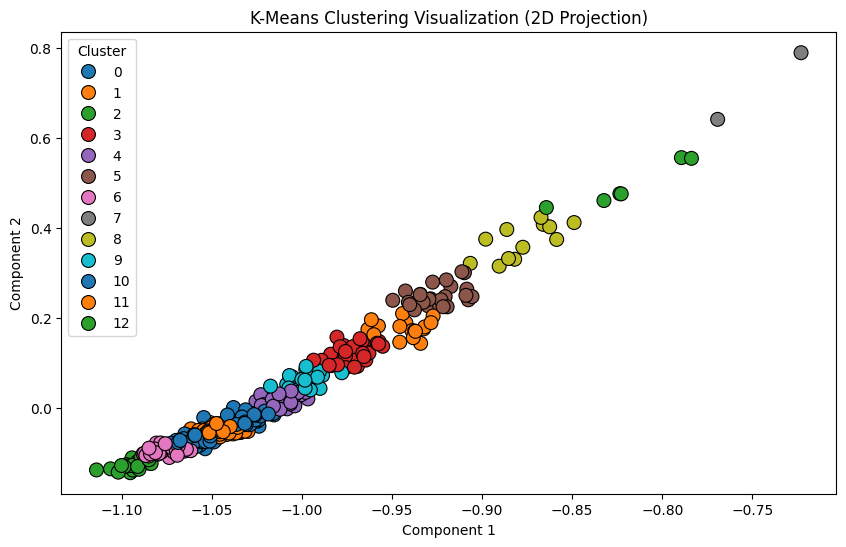

2025-03-09 14:53:54,214 : INFO : collecting all words and their counts
2025-03-09 14:53:54,214 : WARNING : Each 'sentences' item should be a list of words (usually unicode strings). First item here is instead plain <class 'str'>.
2025-03-09 14:53:54,216 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-03-09 14:53:54,222 : INFO : collected 38 word types from a corpus of 24723 raw words and 453 sentences
2025-03-09 14:53:54,224 : INFO : Creating a fresh vocabulary
2025-03-09 14:53:54,226 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 38 unique words (100.00% of original 38, drops 0)', 'datetime': '2025-03-09T14:53:54.225719', 'gensim': '4.3.3', 'python': '3.12.9 (tags/v3.12.9:fdb8142, Feb  4 2025, 15:27:58) [MSC v.1942 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'prepare_vocab'}
2025-03-09 14:53:54,226 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 24723 word corpus (100.00% of origi

Finished displaying at: 2025-03-09 14:53:54 

Finished executing at: 2025-03-09 14:53:54 

Executed at: 2025-03-09 14:53:54 



2025-03-09 14:53:54,411 : INFO : EPOCH 9: training on 24723 raw words (4645 effective words) took 0.0s, 605409 effective words/s
2025-03-09 14:53:54,428 : INFO : EPOCH 10: training on 24723 raw words (4671 effective words) took 0.0s, 850804 effective words/s
2025-03-09 14:53:54,445 : INFO : EPOCH 11: training on 24723 raw words (4650 effective words) took 0.0s, 437293 effective words/s
2025-03-09 14:53:54,463 : INFO : EPOCH 12: training on 24723 raw words (4707 effective words) took 0.0s, 533891 effective words/s
2025-03-09 14:53:54,477 : INFO : EPOCH 13: training on 24723 raw words (4791 effective words) took 0.0s, 606994 effective words/s
2025-03-09 14:53:54,491 : INFO : EPOCH 14: training on 24723 raw words (4755 effective words) took 0.0s, 805236 effective words/s
2025-03-09 14:53:54,506 : INFO : EPOCH 15: training on 24723 raw words (4612 effective words) took 0.0s, 879448 effective words/s
2025-03-09 14:53:54,522 : INFO : EPOCH 16: training on 24723 raw words (4635 effective word

sg=0, Vector_Size=300, Window=3, Epoch=50
Finished displaying at: 2025-03-09 14:53:55 

Executing 13 start time: 2025-03-09 14:53:55
K=13: Silhouette Score and WSS=0.1404	3.3545

Cluster 0:
- PM Shehbaz invites Turkish businessmen to invest in Pakistan’s diverse fields
- Law minister defends IMF team meeting with CJP
- Pakistan keen to increase trade, investment with Japan: Governor
- "Not my King': Anti-monarchy protesters chant at King Charles during visit to Middlesbrough
- Remembering Faiz: A Bengali kid’s first lessons in poetry & politics

Cluster 1:
- Blast at coal mine in Harnai claims 9 lives, leaves 6 injured
- Solar panel imports: 80 companies transferred around Rs106bn abroad: FBR
- More than 500 million take ‘holy dip’ in India’s Maha Kumbh festival
- JazzCash, Mobilink Bank named finalists for prestigious GLOMO Awards 2025
- Sri Lanka hammer Australia in record 174-run rout

Cluster 2:
- Israeli military killed 85 journalists in 2024: CPJ
- UK Pound further climbs up agai

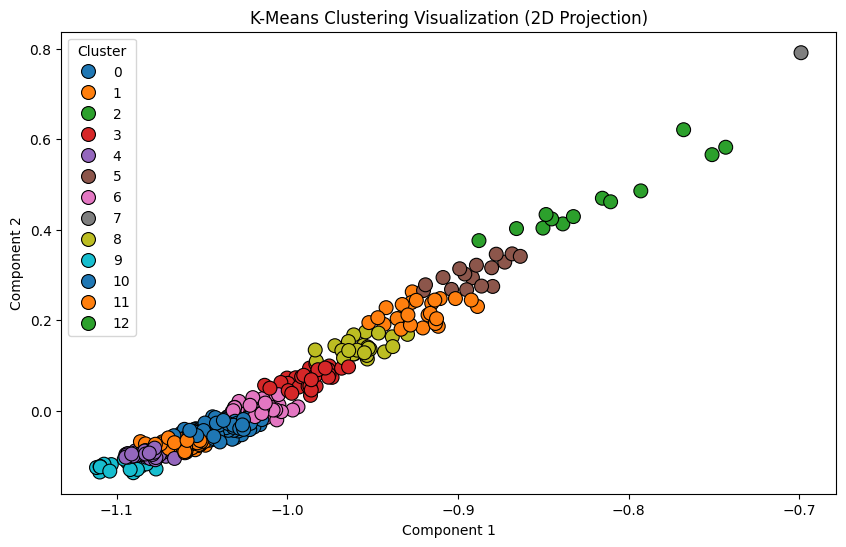

Finished displaying at: 2025-03-09 14:53:55 

Finished executing at: 2025-03-09 14:53:55 



In [116]:
best_combination, best_Sil, best_WSS = run_combinations(13, best_combination, best_Sil, best_WSS)

In [117]:
# Convert to DataFrame for easy export
results_df = pd.DataFrame(results, columns=['k', 'Vectorizer Type', 'vector_size', 'window', 'Epochs Count', 'Vectorizer Name', 'Silhouette Score', 'WSS Score'])

# Save results
results_df.to_csv("clustering_results.csv", index=False)

results_df

,k,Vectorizer Type,vector_size,window,Epochs Count,Vectorizer Name,Silhouette Score,WSS Score
0,5,Word2Vec,50,3,50,CBOW,0.164508,5.581144
1,5,Word2Vec,100,3,50,CBOW,0.189690,6.323141
2,5,Word2Vec,150,3,50,CBOW,0.206452,5.692393
3,5,Word2Vec,200,3,50,CBOW,0.204286,5.186473
4,5,Word2Vec,250,3,50,CBOW,0.172318,4.716859
5,5,Word2Vec,300,3,50,CBOW,0.179618,4.917390
6,9,Word2Vec,50,3,50,CBOW,0.126778,5.202651
7,9,Word2Vec,100,3,50,CBOW,0.125722,4.352470
8,9,Word2Vec,150,3,50,CBOW,0.138728,4.357678
9,9,Word2Vec,200,3,50,CBOW,0.140140,3.865968


In [118]:
# Convert to DataFrame for easy export
wss_scores_df = pd.DataFrame(wss_scores, columns=['k', 'Average WSS Score'])

wss_scores_df

,k,Average WSS Score
0,5,5.402900
1,9,4.150746
2,13,3.832944


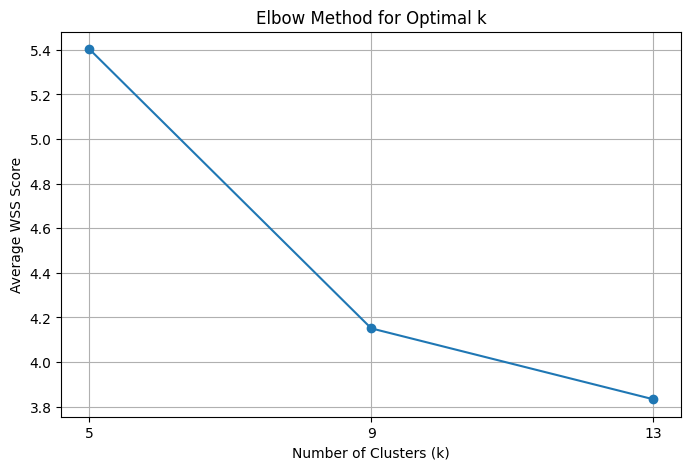

In [119]:
# Plot the elbow plot
plt.figure(figsize=(8, 5))
plt.plot(wss_scores_df['k'], wss_scores_df['Average WSS Score'], marker='o', linestyle='-')

# Add labels and title
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Average WSS Score")
plt.title("Elbow Method for Optimal k")
plt.xticks(wss_scores_df['k'])  # Ensure all k values are shown on x-axis
plt.grid(True)

# Show the plot
plt.show()

In [120]:
best_combination # vector size, window size, epoch

[5, 200, 3, 50, 0.20428638, 5.186473369598389]